# **F1 Pit Stop Prediction**

This project was developed using the **FastF1** library data and aims to predict if the driver will be going to the pits in the next lap.<br>
To collect the data, the team developed a `data_collection.py` script. This script allows the user to collect lap, telemetry and weather data.

The metadata of the datasets used in this project can be found at the **FastF1** documentation page, at https://docs.fastf1.dev/core.html. (Visited on May 10th, 2025)

## 0. Imports, Constants and Helper Functions

**Libraries**

In [1]:
# Import libraries
import os
from pathlib import Path
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract, regexp_replace, col, when, to_timestamp, lead, avg, lag, max, sum, first, last, split, coalesce, lit
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

**Constants**

In [2]:
# Define constants

# Directories
ROOT = Path.cwd().parent
DATA_DIR = ROOT / "data"

# Colors
BLUE = '#003773'
RED = '#ED1E36'
YELLOW = '#FABB23'
TEAM_COLORS = {
    'Red Bull Racing': BLUE
    ,'Mercedes': '#00A19B'
    ,'Ferrari': '#A6051A'
    ,'McLaren': '#FF8700'
    ,'Aston Martin': '#00665E'
    ,'Alpine': '#FD4BC7'
    ,'AlphaTauri': '#00293F'
    ,'Alfa Romeo': '#972738'
    ,'Haas F1 Team': '#AEAEAE'
    ,'Williams': '#00A3E0'
}

# Colormap
CMAP = (
    mcolors
    .LinearSegmentedColormap
    .from_list(
        "my_cmap"
        ,[BLUE, YELLOW, RED]
    )
)

COMPOUND_COLORS = {
    'SOFT': '#F20704'
    ,'MEDIUM': '#FACA08'
    ,'HARD': '#000000'
    ,'INTERMEDIATE': '#029405'
    ,'WET': '#078CD1'
}

# Plot constants
EVENT_PLT = 'British Grand Prix'
YEAR_PLT = 2022
DRIVER_PLT = 'VER'

# Features
LAP_METRIC = [
    'LapTime'
    ,'LapNumber'
    ,'Stint'
    ,'PitOutTime'
    ,'PitInTime'
    ,'Sector1Time'
    ,'Sector2Time'
    ,'Sector3Time'
    ,'SpeedI1'
    ,'SpeedI2'
    ,'SpeedFL'
    ,'SpeedST'
    ,'TyreLife'
    ,'LapStartTime'
    ,'LapSessionTime'
]
LAP_CATEGORICAL = [
    'Driver'
    ,'DriverNumber'
    ,'IsPersonalBest'
    ,'Compound'
    ,'FreshTyre'
    ,'Team'
    ,'TrackStatus'
    ,'Position'
    ,'Deleted'
    ,'FastF1Generated'
    ,'IsAccurate'
    ,'Year'
    ,'EventName'
    ,'Session'
]
TELEMETRY_METRIC = [
    'RPM'
    ,'Speed'
    ,'Throttle'
    ,'SessionTime'
    ,'Distance'
    ,'LapNumber'
]
TELEMETRY_CATEGORICAL = [
    'nGear'
    ,'Brake'
    ,'DRS'
    ,'Driver'
    ,'Year'
    ,'EventName'
    ,'Session'
    ,'IsDRSActive'
]

**Helper Functions**

In [3]:
# Define helper function for number of bins in histogram
def sturges_bins(data, column_name):
    """
    Calculates the number of bins for a histogram using Sturges' Rule.
    
    Parameters:
    data (pd.DataFrame): The dataset containing the column.
    column_name (str): The name of the column to calculate the number of bins for.
    
    Returns:
    int: The number of bins calculated using Sturges' Rule.
    """
    # Number of data points
    n = len(data[column_name])
    
    # Calculate the number of bins using Sturges' Rule
    k = int(np.ceil(np.log2(n) + 1))
    
    return k

## 1. Data Loading

In this section, the spark session is initiliazed and the data is ingested.

In [4]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Lap Data Aggregation") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/14 22:11:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


`TODO`: Implement data to be loaded from databricks

Upload the file through the UI
- Go to the Data tab on the left sidebar in your Databricks workspace.
- Click "Add Data" → then choose "Upload File".
- Upload your file (e.g., CSV, JSON, Parquet).
- Databricks will store it in something like:
    /FileStore/tables/your_filename.csv

You can then access it like this:
df = spark.read.option("header", "true").csv("/FileStore/tables/your_filename.csv")
df.show()


### 1.1. Lap Data

In [5]:
# Load the data
lap_data = (
    spark.read
    .option("header", True)
    .option("inferSchema", "true")
    .csv(f"{DATA_DIR}/laps.csv")
)

#### 1.1.1. Feature Analysis

After analysing the available metadata, some features are removed from the dataframe, as they do not bring necessary value to the problem solution.

In [6]:
# Dropping irrelevant columns
lap_data = lap_data.drop(
    "Sector1SessionTime"
    ,"Sector2SessionTime"
    ,"Sector3SessionTime"
    ,"LapStartDate"
    ,"DeletedReason"
)

#### 1.1.2. Fixing Datatypes

In [7]:
# Check datatypes
lap_data.printSchema()

root
 |-- Time: string (nullable = true)
 |-- Driver: string (nullable = true)
 |-- DriverNumber: integer (nullable = true)
 |-- LapTime: string (nullable = true)
 |-- LapNumber: double (nullable = true)
 |-- Stint: double (nullable = true)
 |-- PitOutTime: string (nullable = true)
 |-- PitInTime: string (nullable = true)
 |-- Sector1Time: string (nullable = true)
 |-- Sector2Time: string (nullable = true)
 |-- Sector3Time: string (nullable = true)
 |-- SpeedI1: double (nullable = true)
 |-- SpeedI2: double (nullable = true)
 |-- SpeedFL: double (nullable = true)
 |-- SpeedST: double (nullable = true)
 |-- IsPersonalBest: boolean (nullable = true)
 |-- Compound: string (nullable = true)
 |-- TyreLife: double (nullable = true)
 |-- FreshTyre: boolean (nullable = true)
 |-- Team: string (nullable = true)
 |-- LapStartTime: string (nullable = true)
 |-- TrackStatus: integer (nullable = true)
 |-- Position: double (nullable = true)
 |-- Deleted: boolean (nullable = true)
 |-- FastF1Generat

In [8]:
# Fix datatypes
lap_data = (
    lap_data
    .withColumn("LapSessionTime", split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapTime", split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapNumber", col("LapNumber").cast(IntegerType()))
    .withColumn("Stint", col("Stint").cast(IntegerType()))
    .withColumn("PitOutTime", split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("PitInTime", split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector1Time", split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector2Time", split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector3Time", split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("SpeedI1", col("SpeedI1").cast(IntegerType()))
    .withColumn("SpeedI2", col("SpeedI2").cast(IntegerType()))
    .withColumn("SpeedFL", col("SpeedFL").cast(IntegerType()))
    .withColumn("SpeedST", col("SpeedST").cast(IntegerType()))
    .withColumn("TyreLife", col("TyreLife").cast(IntegerType()))
    .withColumn("LapStartTime", split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Position", col("Position").cast(IntegerType()))
    .withColumn("Year", col("Year").cast(IntegerType()))
)

lap_data = lap_data.drop(col("Time"))

In [9]:
# # Show the result
# lap_data.show(1)

### 1.2. Telemetry Data

In [10]:
telemetry_data = (
    spark.read
    .option("header", True)
    .option("inferSchema", "true")
    .csv(f"{DATA_DIR}/telemetry.csv")
)

#### 1.2.1. Feature Analysis

After analysing the available metadata, some features are removed from the dataframe, as they do not bring necessary value to the problem solution.

In [11]:
telemetry_data = telemetry_data.drop(
    "Date"
    ,"DataCollectionTime"
    ,"Time"
    ,"Source"
)

#### 1.2.2. Fixing Datatypes

In [12]:
# Check datatypes
telemetry_data.printSchema()

root
 |-- RPM: double (nullable = true)
 |-- Speed: double (nullable = true)
 |-- nGear: integer (nullable = true)
 |-- Throttle: double (nullable = true)
 |-- Brake: boolean (nullable = true)
 |-- DRS: integer (nullable = true)
 |-- SessionTime: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Driver: string (nullable = true)
 |-- LapNumber: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- EventName: string (nullable = true)
 |-- Session: string (nullable = true)



In [13]:
telemetry_data = (
    telemetry_data
    .withColumn("RPM", col("RPM").cast(IntegerType()))
    .withColumn("Speed", col("Speed").cast(IntegerType()))
    .withColumn("Throttle", col("Throttle").cast(IntegerType()))
    .withColumn("Brake", col("Brake").cast(BooleanType()).cast(IntegerType()))
    .withColumn(
        "SessionTime", split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapNumber", col("LapNumber").cast(IntegerType()))
    .withColumn("Year", col("Year").cast(IntegerType()))
    .withColumn(
        "IsDRSActive", when(
            col("DRS").isin(10, 12, 14), 1
        ).otherwise(0)
    )
)

In [14]:
# Show the result
telemetry_data.show(1)

+----+-----+-----+--------+-----+---+-----------+--------+------+---------+----+------------------+-------+-----------+
| RPM|Speed|nGear|Throttle|Brake|DRS|SessionTime|Distance|Driver|LapNumber|Year|         EventName|Session|IsDRSActive|
+----+-----+-----+--------+-----+---+-----------+--------+------+---------+----+------------------+-------+-----------+
|9802|    0|    1|      10|    1|  1|   3754.971|     0.0|   VER|        1|2022|Bahrain Grand Prix|      R|          0|
+----+-----+-----+--------+-----+---+-----------+--------+------+---------+----+------------------+-------+-----------+
only showing top 1 row



## 2. Data Visualization

### 2.1. Lap Data

In [15]:
# Convert the dataframe to pandas for visualization purposes
lap_pd = lap_data.toPandas()

25/05/14 22:11:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### 2.1.1. Histograms

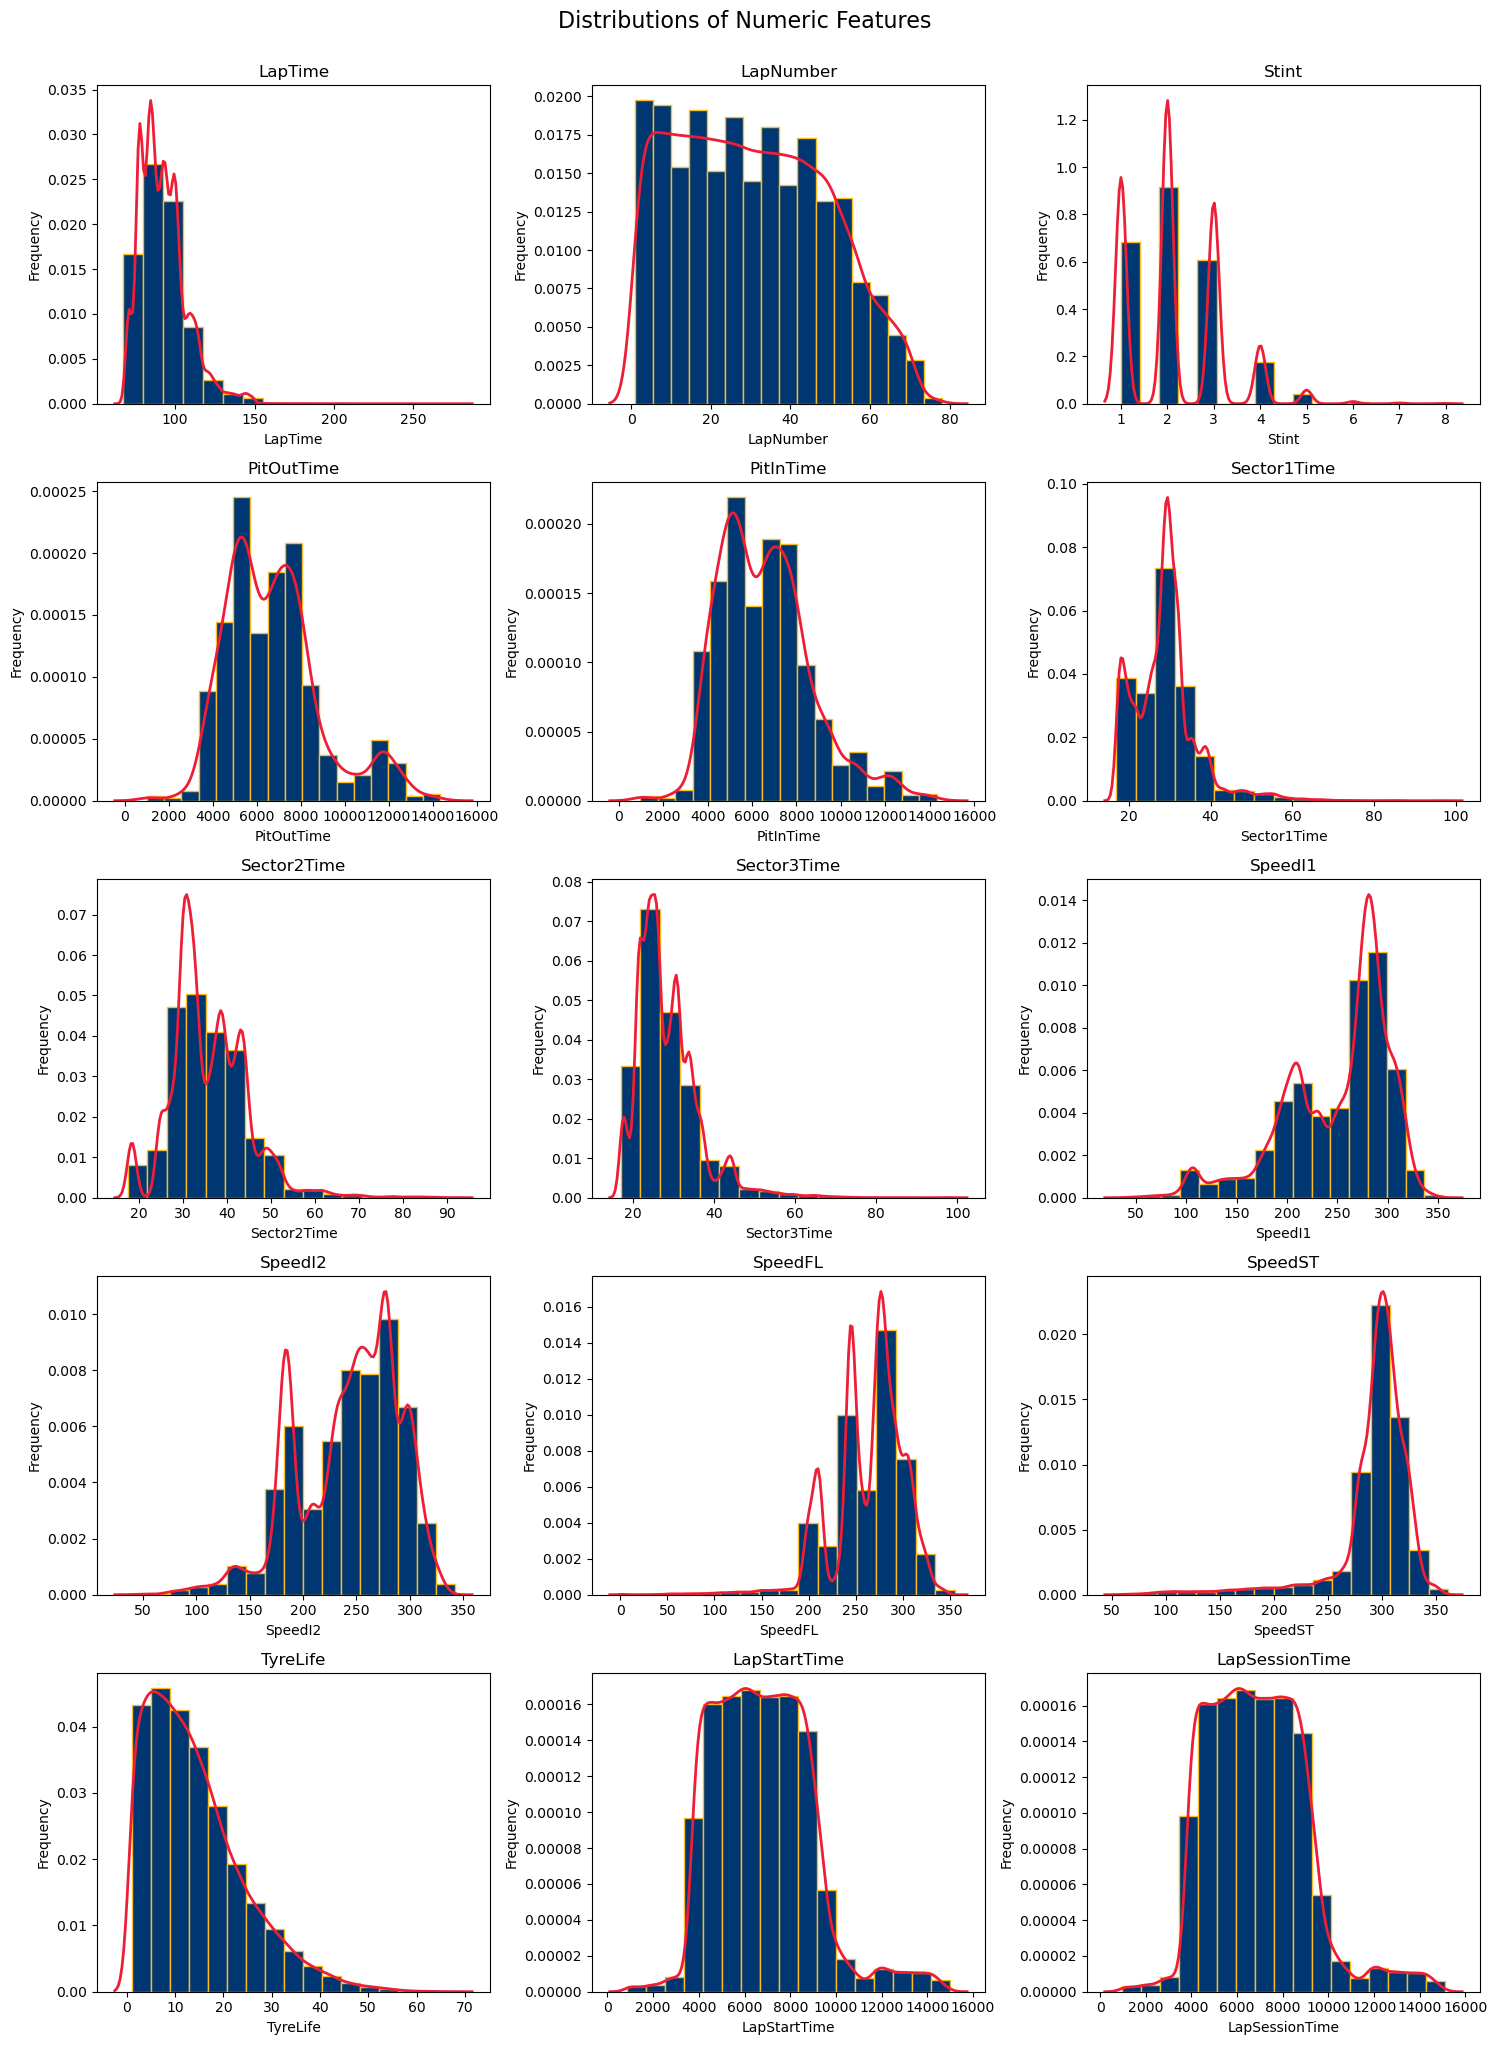

In [16]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(LAP_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot histogram and density line
for i, col_ in enumerate(LAP_METRIC):
    sns.histplot(
        data=lap_pd
        ,x=col_
        ,ax=axes[i]
        ,bins=sturges_bins(lap_pd, col_)
        ,color=BLUE
        ,edgecolor=YELLOW
        ,stat='density'
        ,alpha=1
    )

    sns.kdeplot(
        data=lap_pd
        ,x=col_
        ,ax=axes[i]
        ,color=RED
        ,linewidth=2
    )
    
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Numeric Features", fontsize=16, y=1.02)
plt.show()

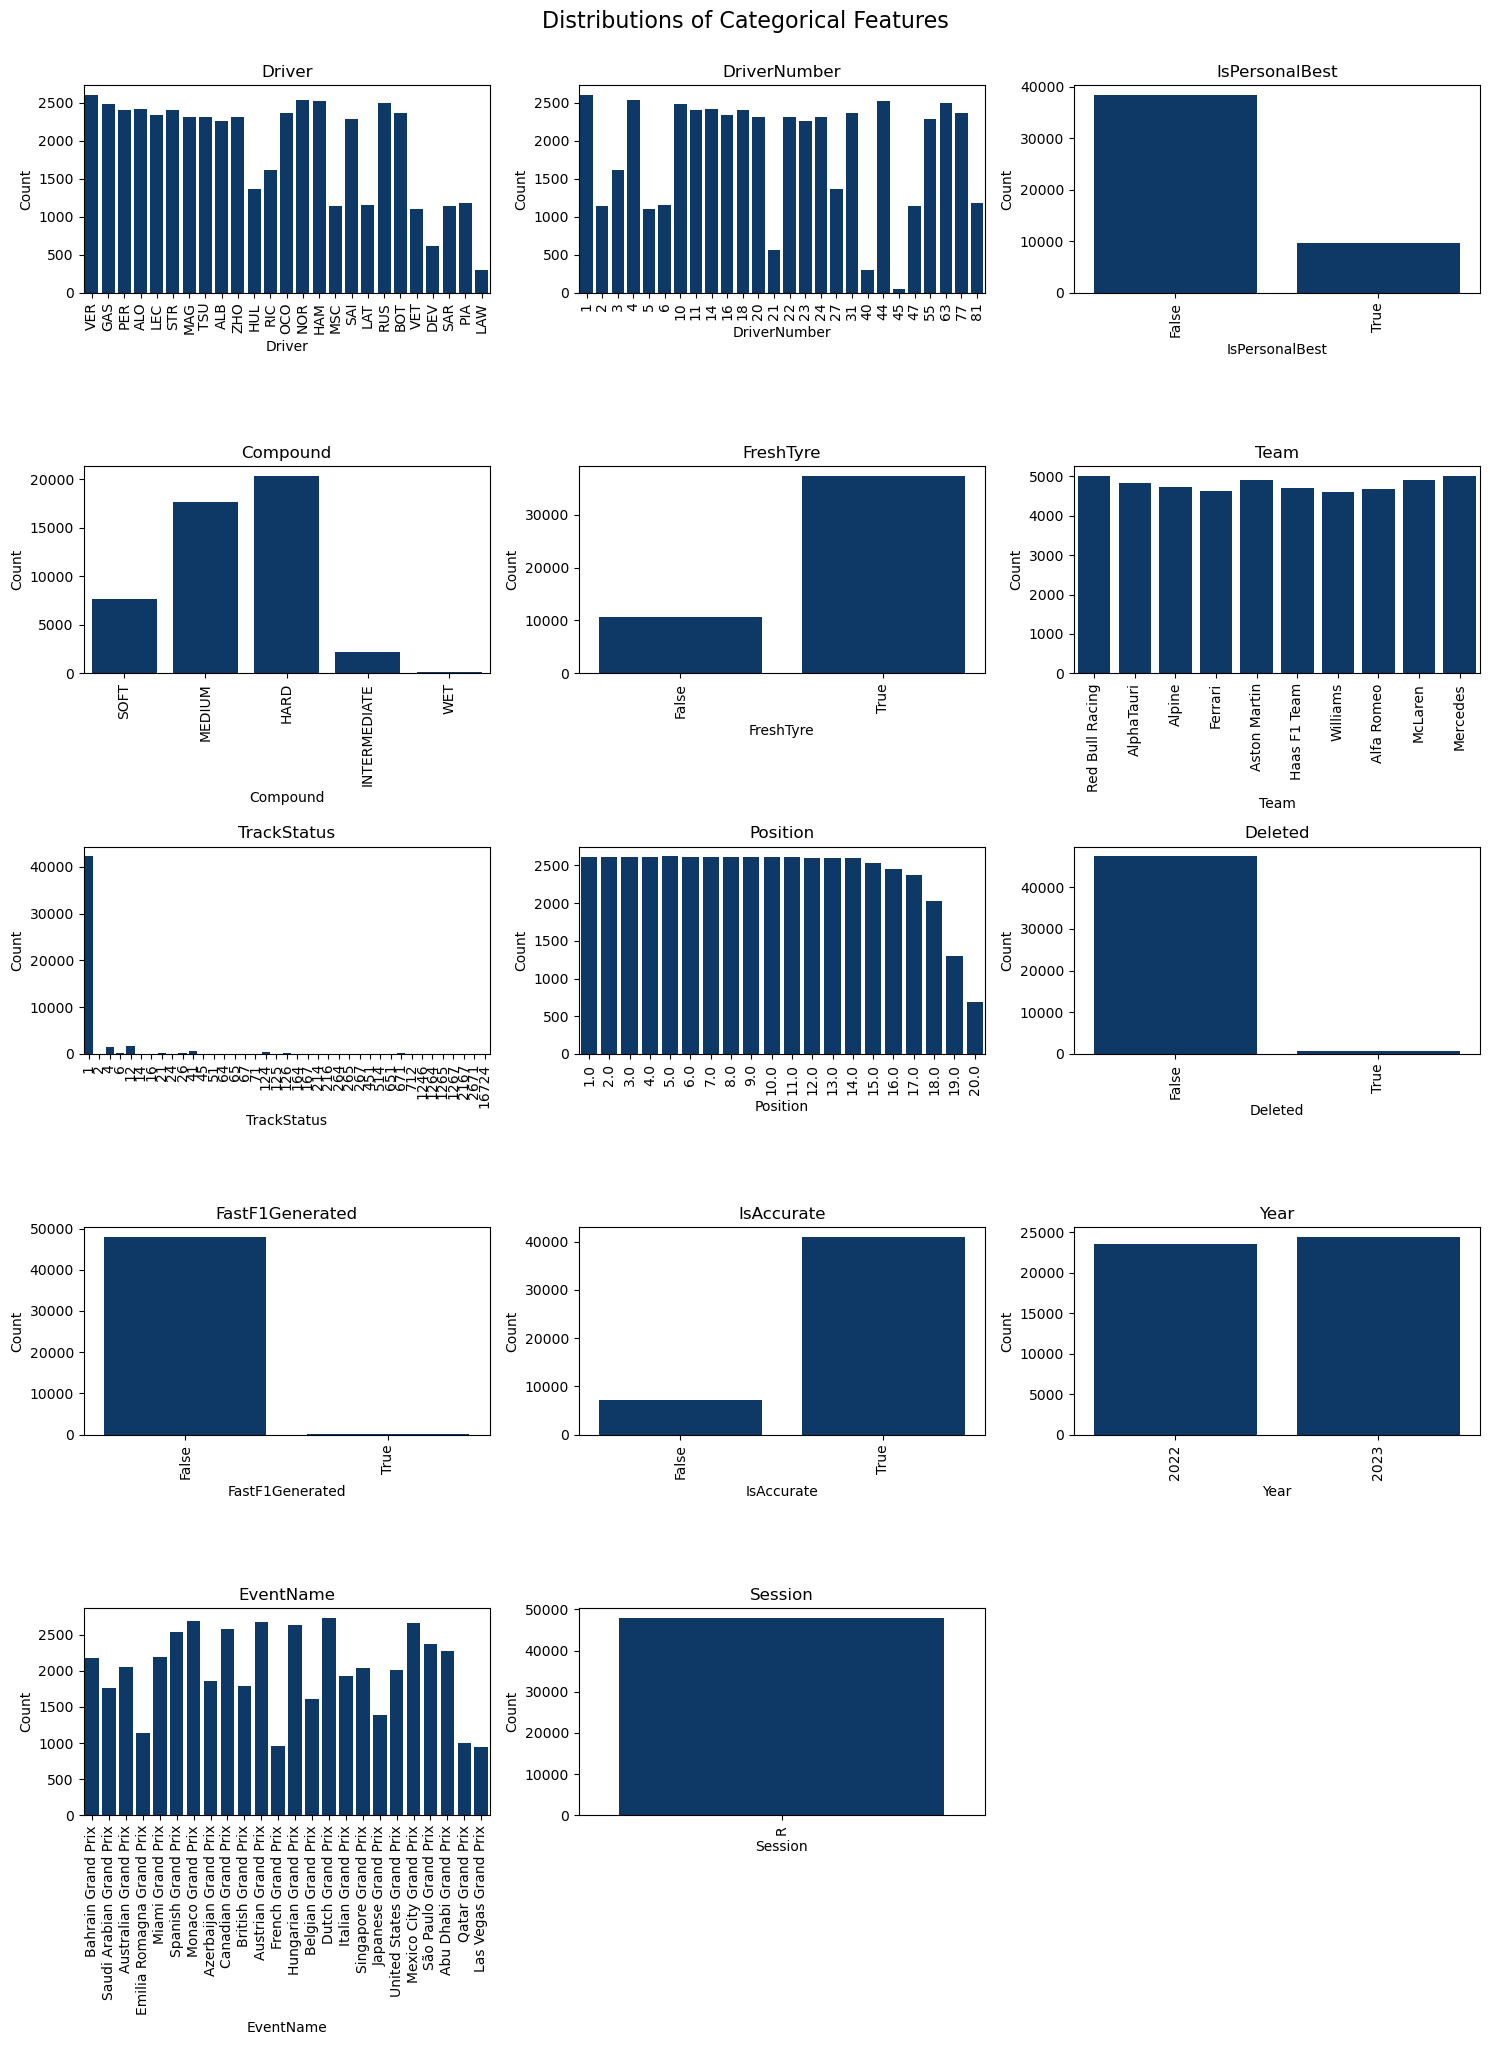

In [17]:
# Plot for categorical features
n_cols = 3
n_rows = int(np.ceil(len(LAP_CATEGORICAL) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col_ in enumerate(LAP_CATEGORICAL):
    sns.countplot(
        data=lap_pd[lap_pd[col_].notna()],
        x=col_,
        ax=axes[i],
        color=BLUE
    )
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Categorical Features", fontsize=16, y=1.02)
plt.show()

#### 2.1.2. Boxplots

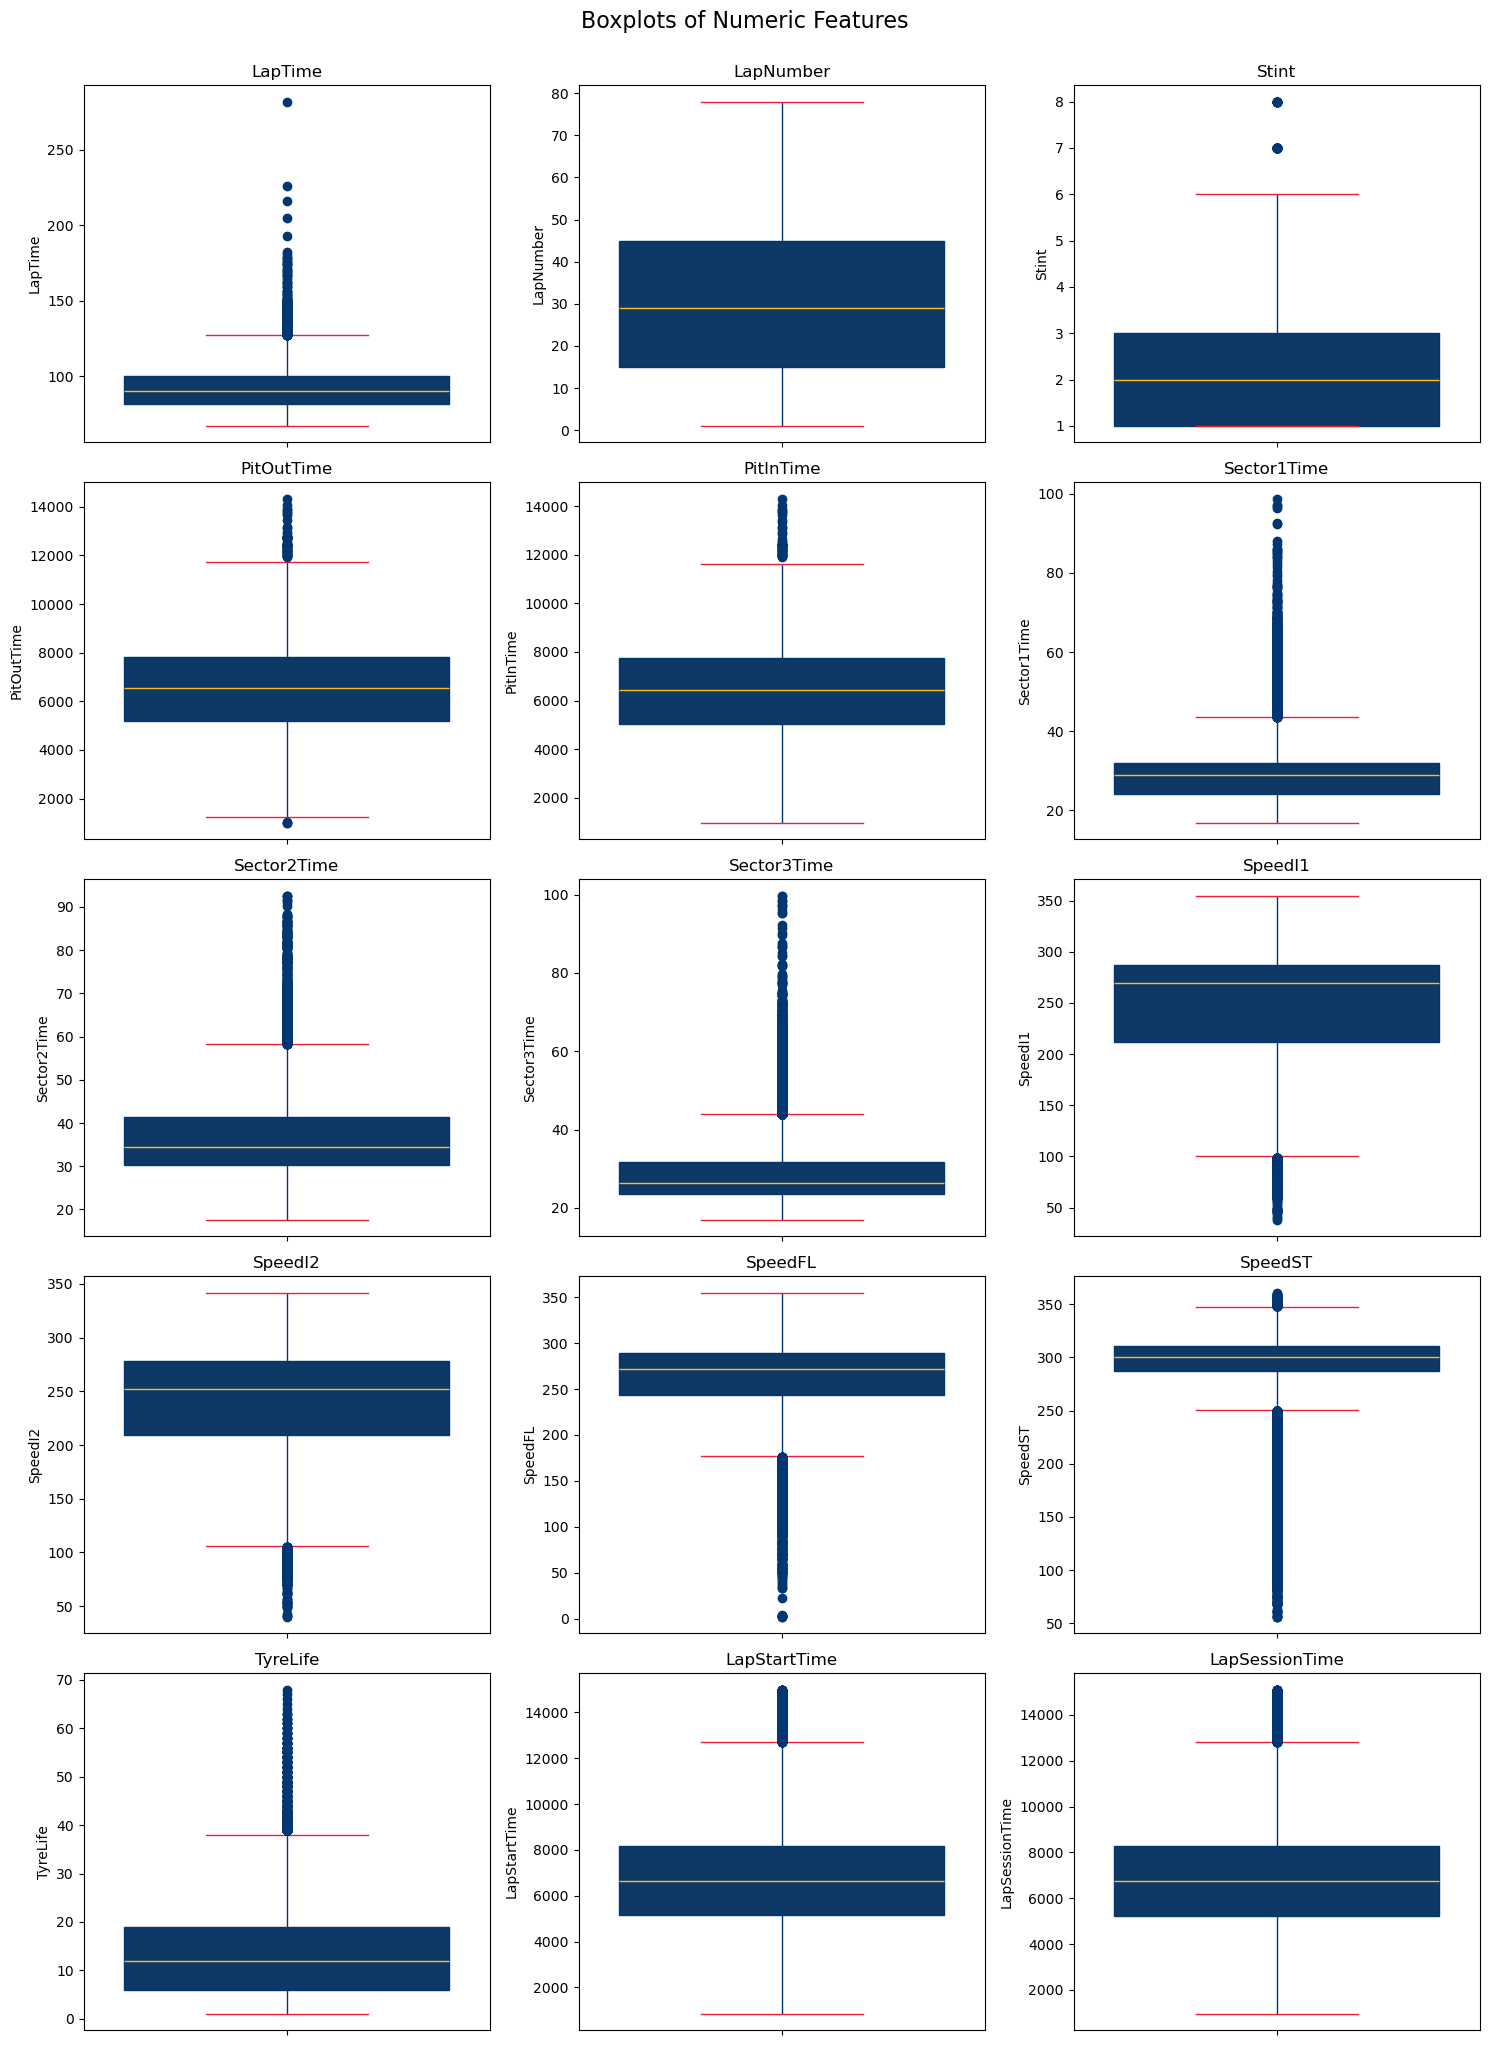

In [18]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(LAP_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col_ in enumerate(LAP_METRIC):
    sns.boxplot(y=lap_pd[col_], ax=axes[i], color=BLUE, boxprops=dict(edgecolor=BLUE),
        whiskerprops=dict(color=BLUE),
        capprops=dict(color=RED),
        medianprops=dict(color=YELLOW),
        flierprops=dict(markerfacecolor=BLUE, markeredgecolor=BLUE))
    axes[i].set_title(col_)
    axes[i].set_ylabel(col_)
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
plt.show()

#### 2.1.3. Other Plots

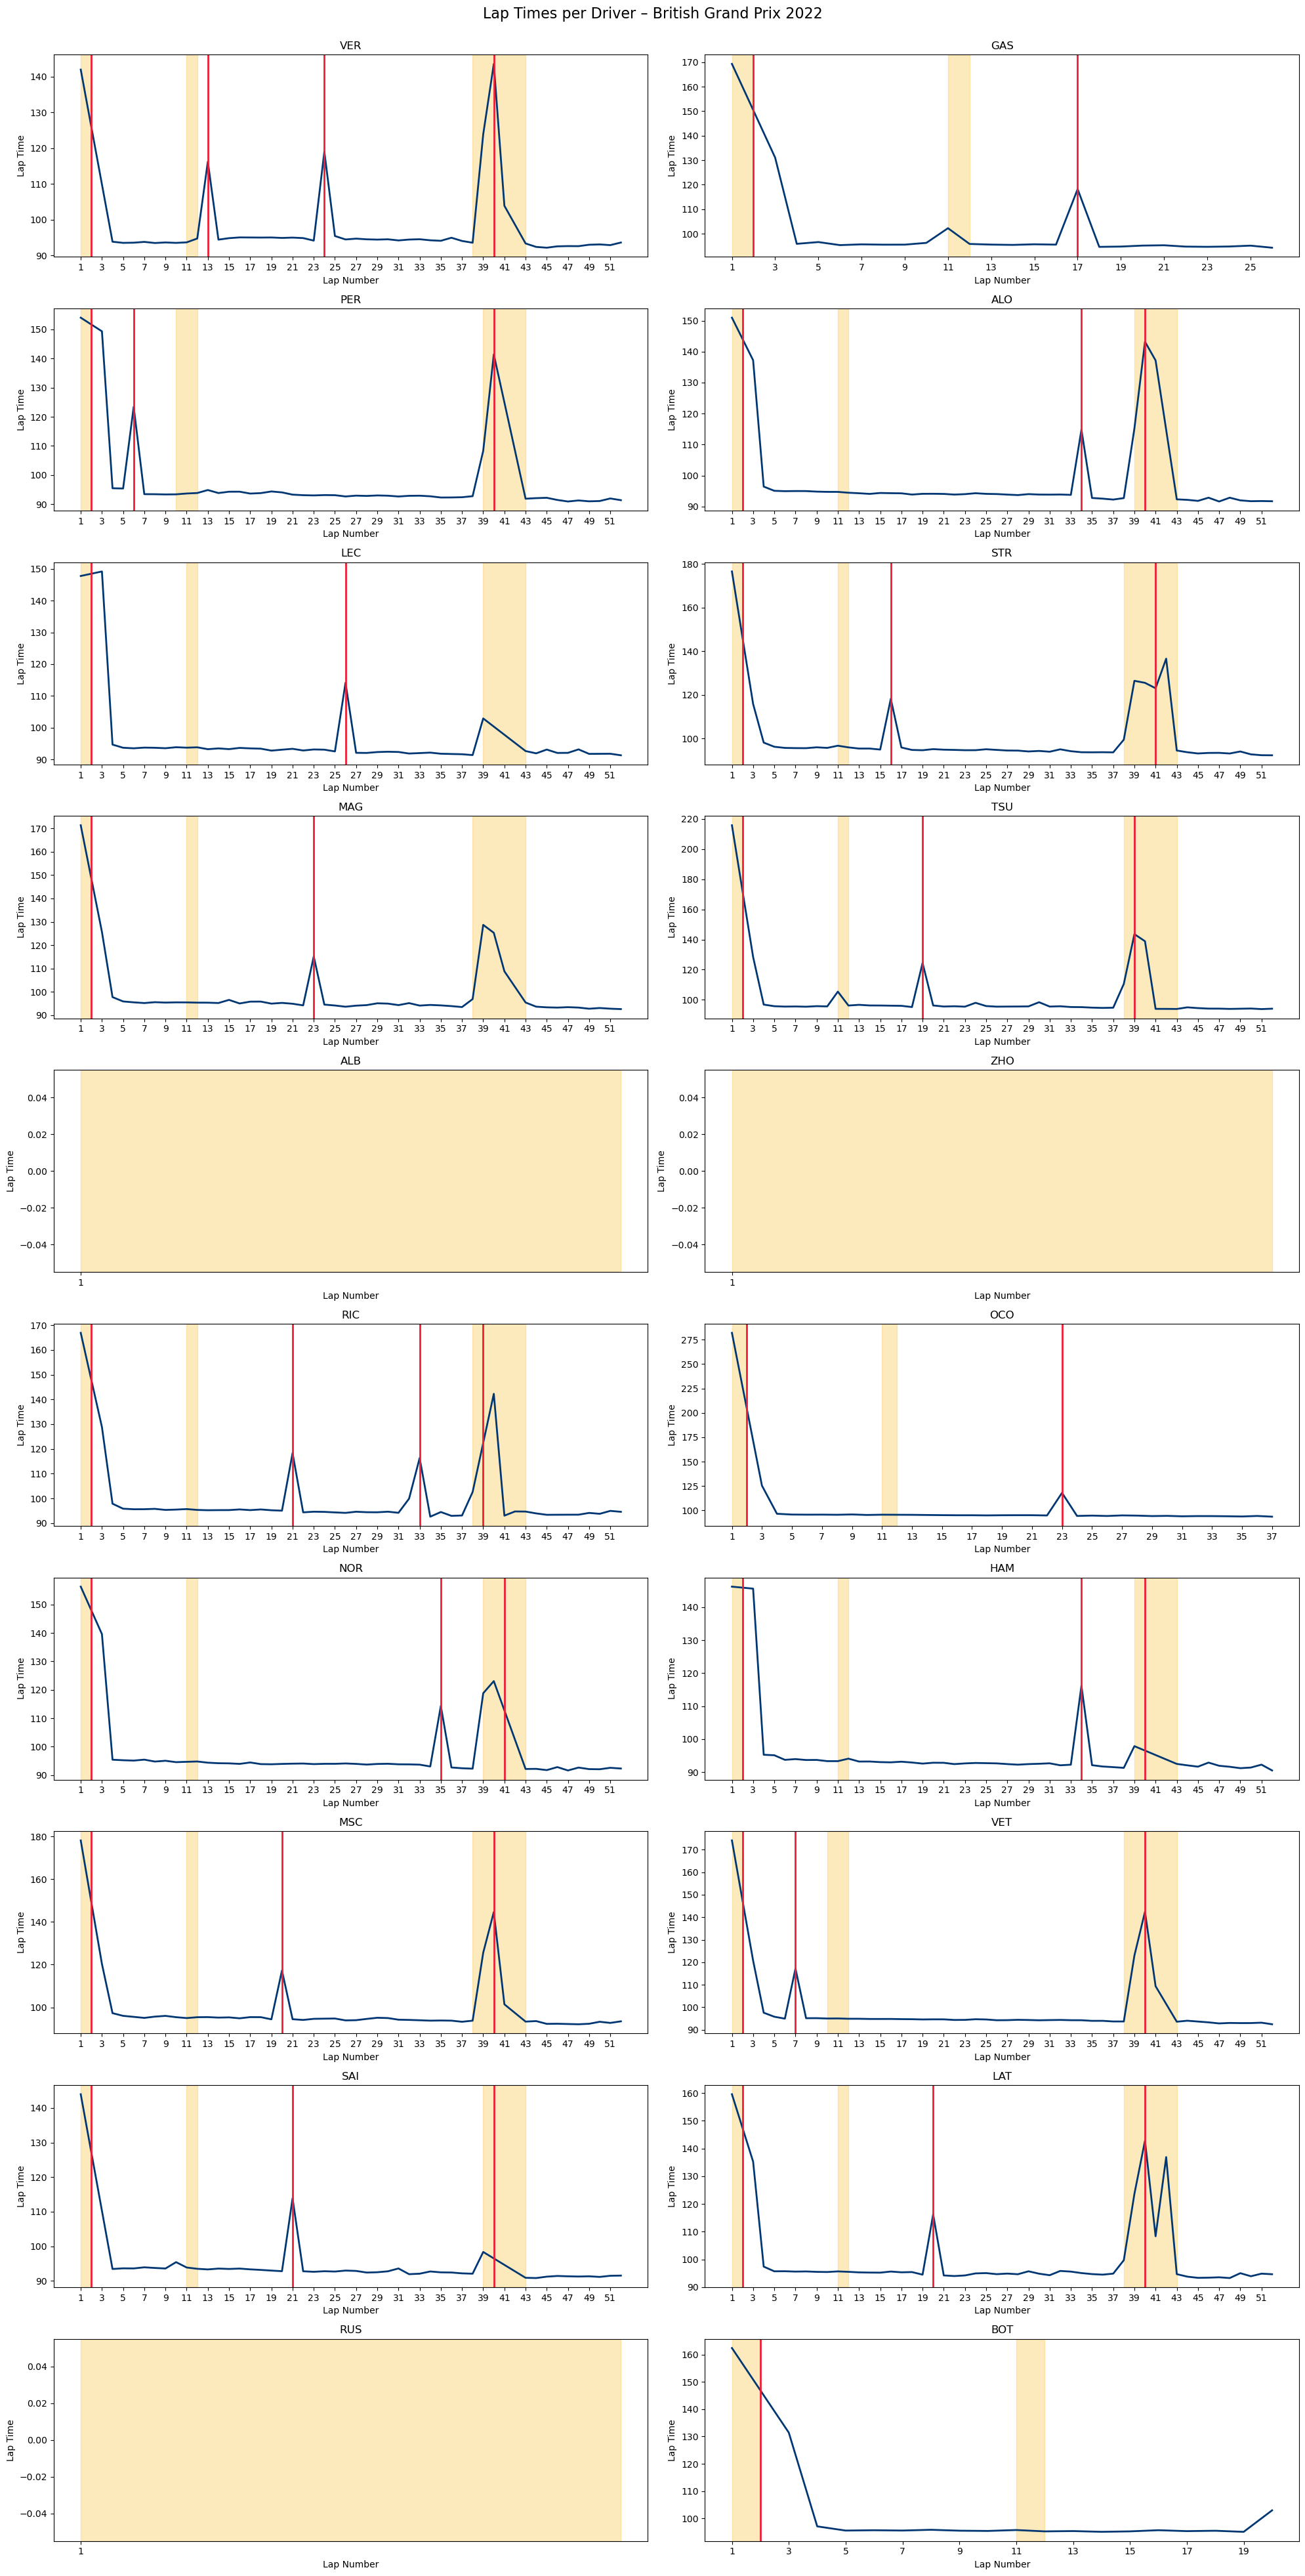

In [19]:
# Filter data
race_df = lap_pd[
    (lap_pd['EventName'] == EVENT_PLT) & 
    (lap_pd['Year'] == YEAR_PLT)
].copy()

n_cols = 2
n_rows = math.ceil(len(race_df['Driver'].unique()) / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=False)
axes = axes.flatten()

for i, driver in enumerate(race_df['Driver'].unique()):
    ax = axes[i]
    driver_laps = race_df[race_df['Driver'] == driver].sort_values('LapNumber')

    # Plot lap time
    sns.lineplot(
        data=driver_laps
        ,x='LapNumber'
        ,y='LapTime'
        ,color=BLUE
        ,linewidth=2
        ,ax=ax
    )

    # Add vertical lines for pit stop
    pit_laps = driver_laps[driver_laps['PitOutTime'].notnull()]['LapNumber'].unique()
    for lap in pit_laps:
        ax.axvline(x=lap, color=RED, linestyle='-', linewidth=2)

    # Shade laps with track status different than Green Flag
    non_green_laps = driver_laps[driver_laps['TrackStatus'] != 1]['LapNumber'].values
    if len(non_green_laps) > 0:
        start = non_green_laps[0]
        for j in range(1, len(non_green_laps)):
            if non_green_laps[j] != non_green_laps[j-1] + 1:
                ax.axvspan(start, non_green_laps[j-1] + 1, color=YELLOW, alpha=0.3)
                start = non_green_laps[j]
        ax.axvspan(start, non_green_laps[-1] + 1, color=YELLOW, alpha=0.3)

    ax.set_title(f"{driver}")
    ax.set_xlabel("Lap Number")
    ax.set_ylabel("Lap Time")
    ax.set_xticks(range(driver_laps['LapNumber'].min(), driver_laps['LapNumber'].max() + 1, 2))


# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add suptitle
fig.suptitle(f"Lap Times per Driver – {EVENT_PLT} {YEAR_PLT}", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

This plot shows the majority of drivers pit when there is a track status change. All drivers racing during the 3rd moment of track status change but two decided to pit.

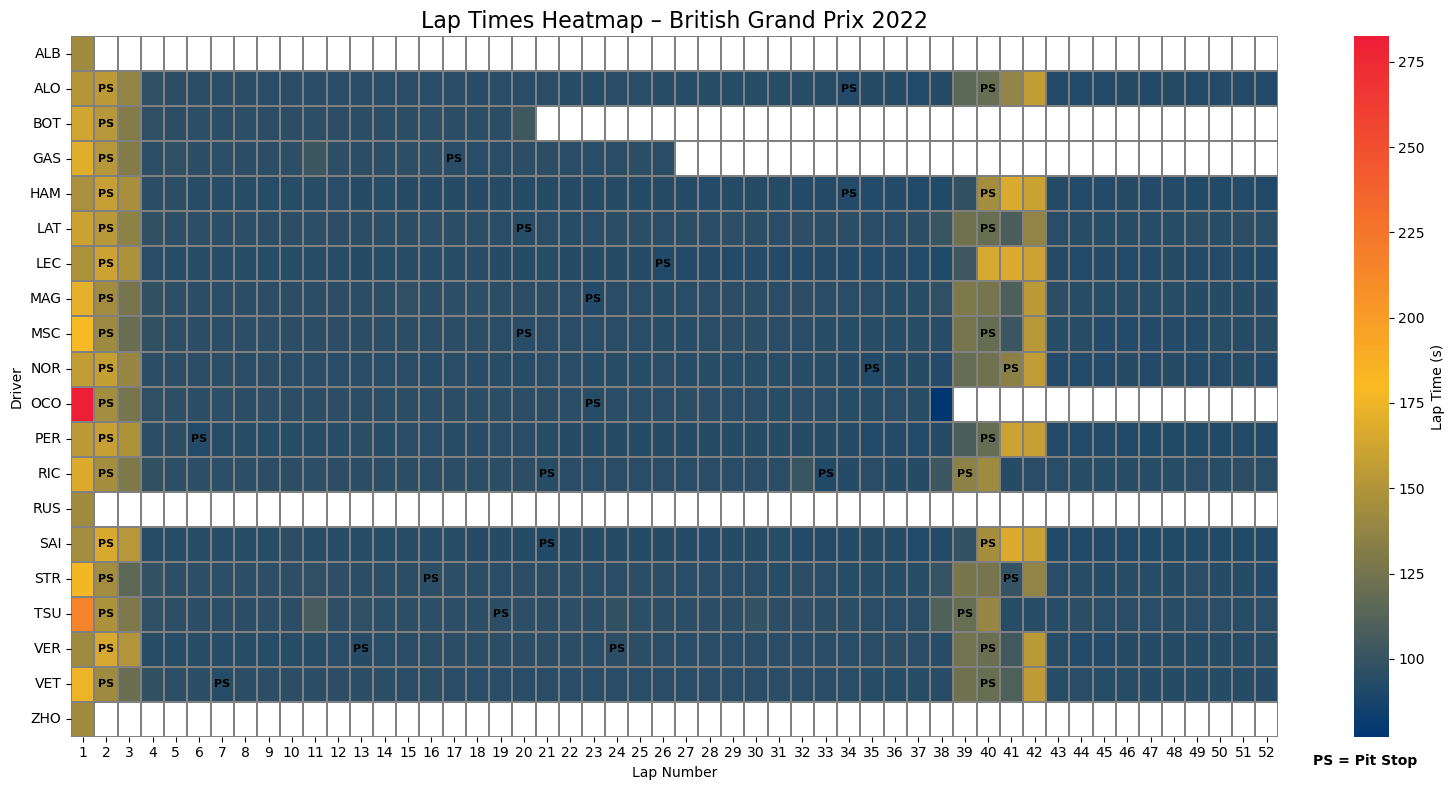

In [20]:
race_df['AdjustedLapTime'] = np.where(
    race_df['PitOutTime'].notna()
    ,race_df['LapSessionTime'] - race_df['LapStartTime'] - (race_df['PitOutTime'] - race_df['LapStartTime'])
    ,race_df['LapSessionTime'] - race_df['LapStartTime']
)

# Pivot the data
heatmap_data = race_df.pivot_table(
    index='Driver',
    columns='LapNumber',
    values='AdjustedLapTime'
)

# Create dataframe for annotations
annotations = pd.DataFrame(
    ''
    ,index=heatmap_data.index
    ,columns=heatmap_data.columns
)
# Filter laps with pit stop
pitstops = race_df[
    (race_df['PitOutTime'].notnull())
]

# Set 'PS' on pit stop laps
for _, row in pitstops.iterrows():
    driver = row['Driver']
    lap = row['LapNumber']
    if driver in annotations.index and lap in annotations.columns:
        annotations.at[driver, lap] = 'PS'

# Create the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data
    ,cmap=CMAP
    ,linewidths=0.2
    ,linecolor='gray'
    ,cbar_kws={'label': 'Lap Time (s)'}
    ,annot=annotations
    ,fmt=''
    ,annot_kws={
        "size": 8
        ,"weight": "bold"
        ,"color": "black"
    }
)

plt.text(
    x=heatmap_data.shape[1] + 1.5
    ,y=heatmap_data.shape[0] + 0.8
    ,s="PS = Pit Stop"
    ,fontsize=10
    ,fontweight='bold'
)

plt.title(f'Lap Times Heatmap – {EVENT_PLT} {YEAR_PLT}', fontsize=16)
plt.xlabel('Lap Number')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

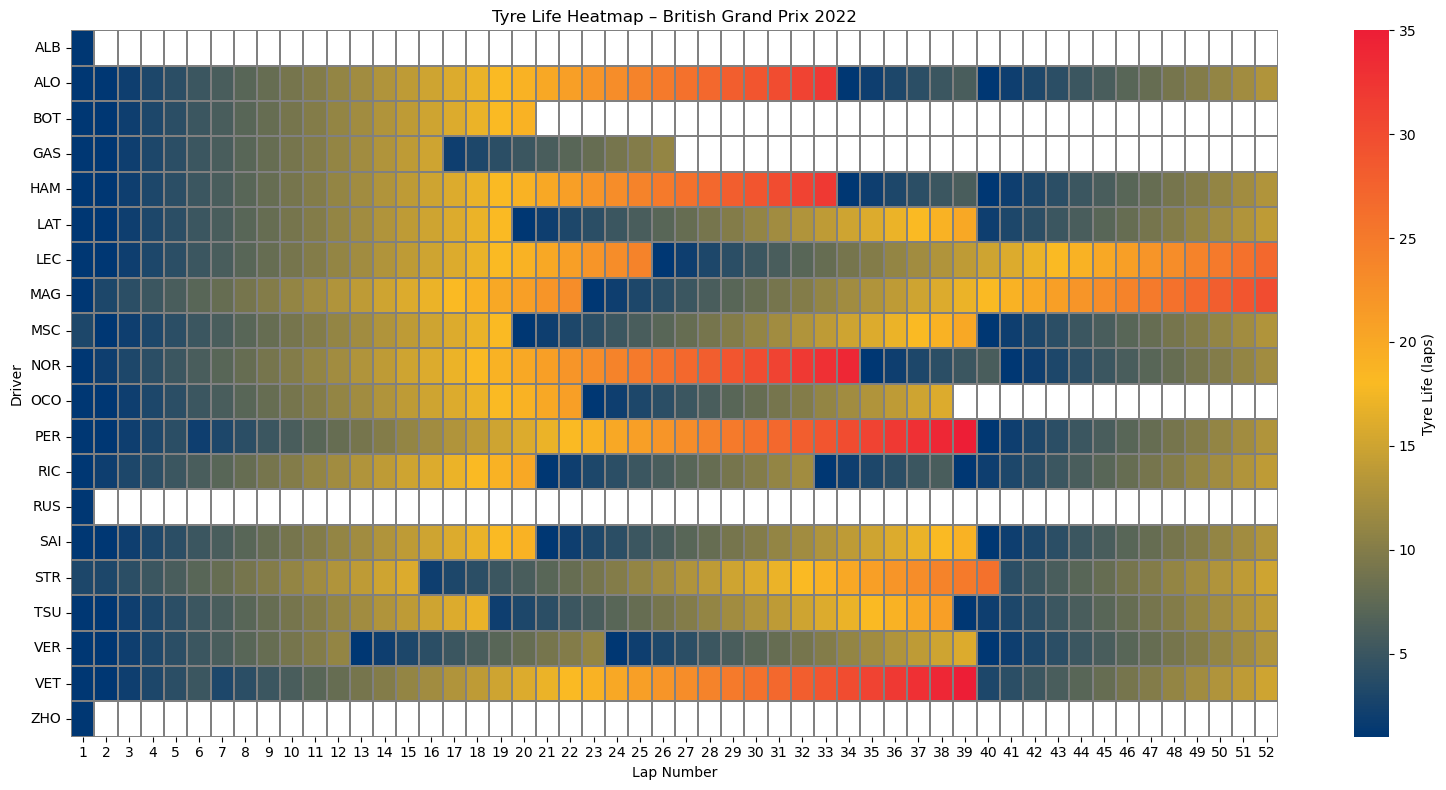

In [21]:
# Pivot the data
heatmap_data = race_df.pivot_table(
    index='Driver',
    columns='LapNumber',
    values='TyreLife'
)

# Create the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    cmap=CMAP,
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label': 'Tyre Life (laps)'}
)

plt.title(f'Tyre Life Heatmap – {EVENT_PLT} {YEAR_PLT}')
plt.xlabel('Lap Number')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

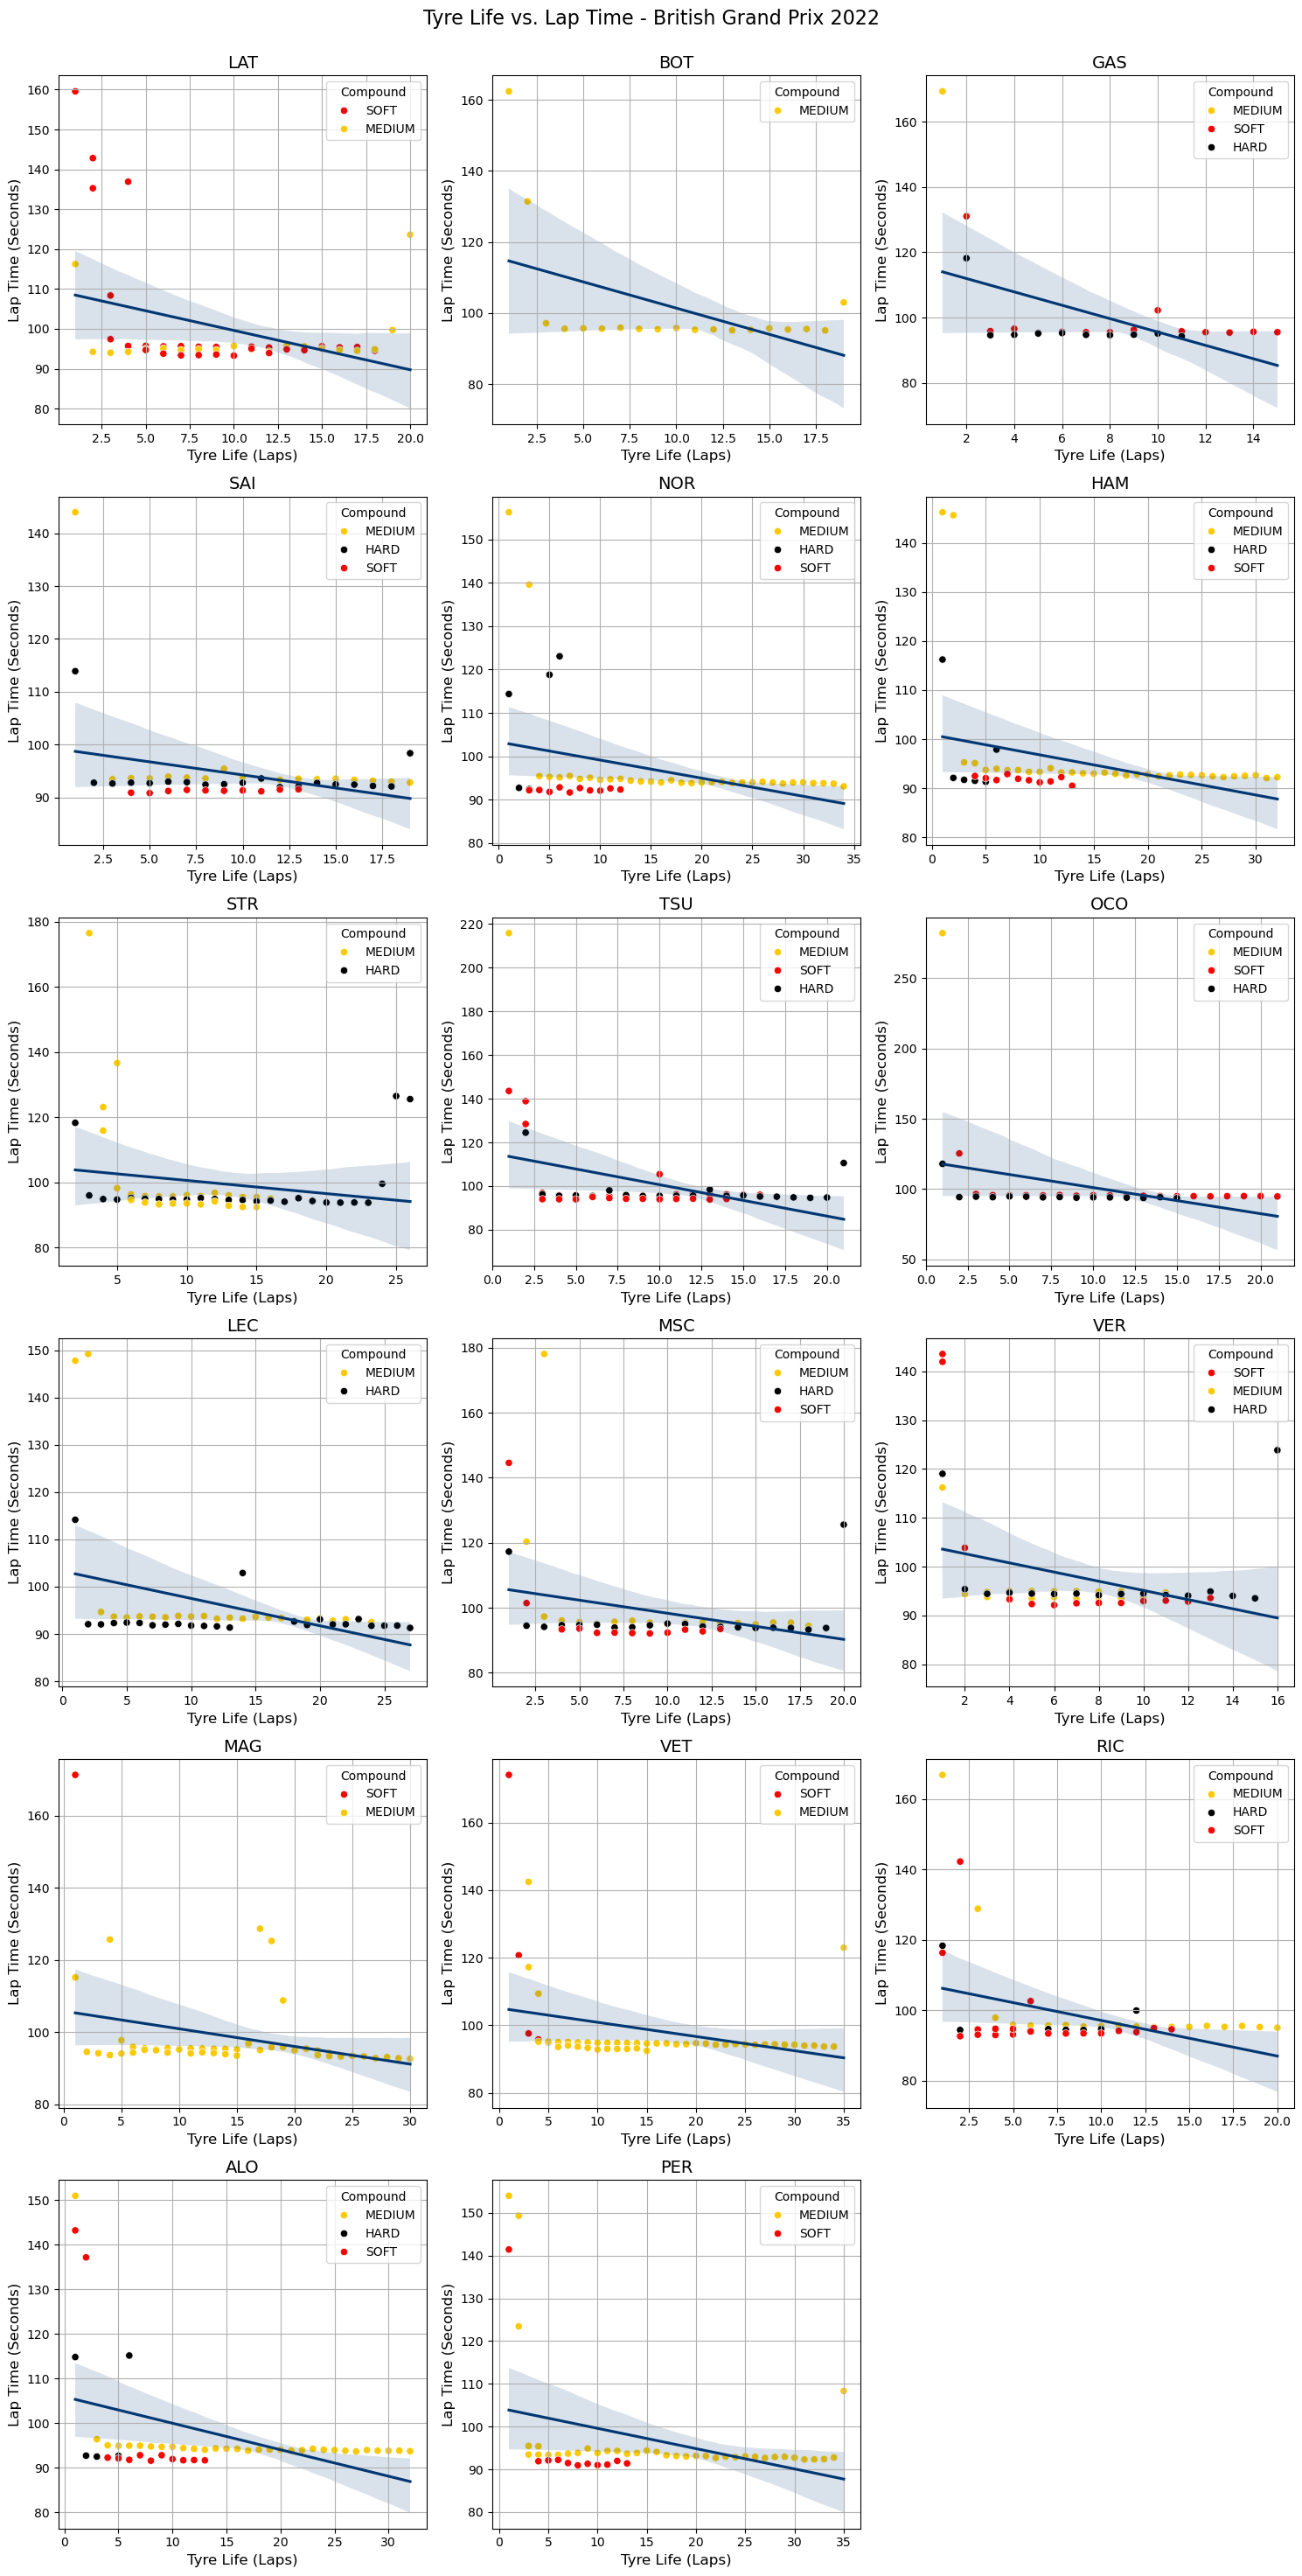

In [22]:
# Filter the data
tyre_life = race_df[(race_df['LapTime'].notna())].sort_values(by='LapNumber')

# Determine the number of rows needed
n_cols = 3
n_rows = (len(tyre_life['Driver'].unique()) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each driver and plot
for i, driver in enumerate(tyre_life['Driver'].unique()):
    # Filter data for the current driver
    driver_data = tyre_life[tyre_life['Driver'] == driver]

    # Create scatter plot for the driver with hue
    sns.scatterplot(
        x='TyreLife', y='LapTime',
        data=driver_data,
        hue='Compound',
        palette=COMPOUND_COLORS,
        ax=axes[i]
    )

    # Add a regression line (single trend, not per compound)
    sns.regplot(
        x='TyreLife', y='LapTime',
        data=driver_data,
        scatter=False,
        color=BLUE,
        ax=axes[i],
        line_kws={'label': 'Trend Line'}
    )

    # Set title and labels for each subplot
    axes[i].set_title(f'{driver}', fontsize=14)
    axes[i].set_xlabel('Tyre Life (Laps)', fontsize=12)
    axes[i].set_ylabel('Lap Time (Seconds)', fontsize=12)
    axes[i].grid(True)

    # Combine legends from both plots (scatter + regplot)
    handles, labels = axes[i].get_legend_handles_labels()
    # Remove duplicates and preserve order
    seen = set()
    new_handles, new_labels = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            new_handles.append(h)
            new_labels.append(l)
            seen.add(l)
    axes[i].legend(new_handles, new_labels, title='Compound')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Tyre Life vs. Lap Time - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

By analysing this plot, it is possible to conclude the first couple of laps on a new set of tyres are usually very slow compared to the remaining.

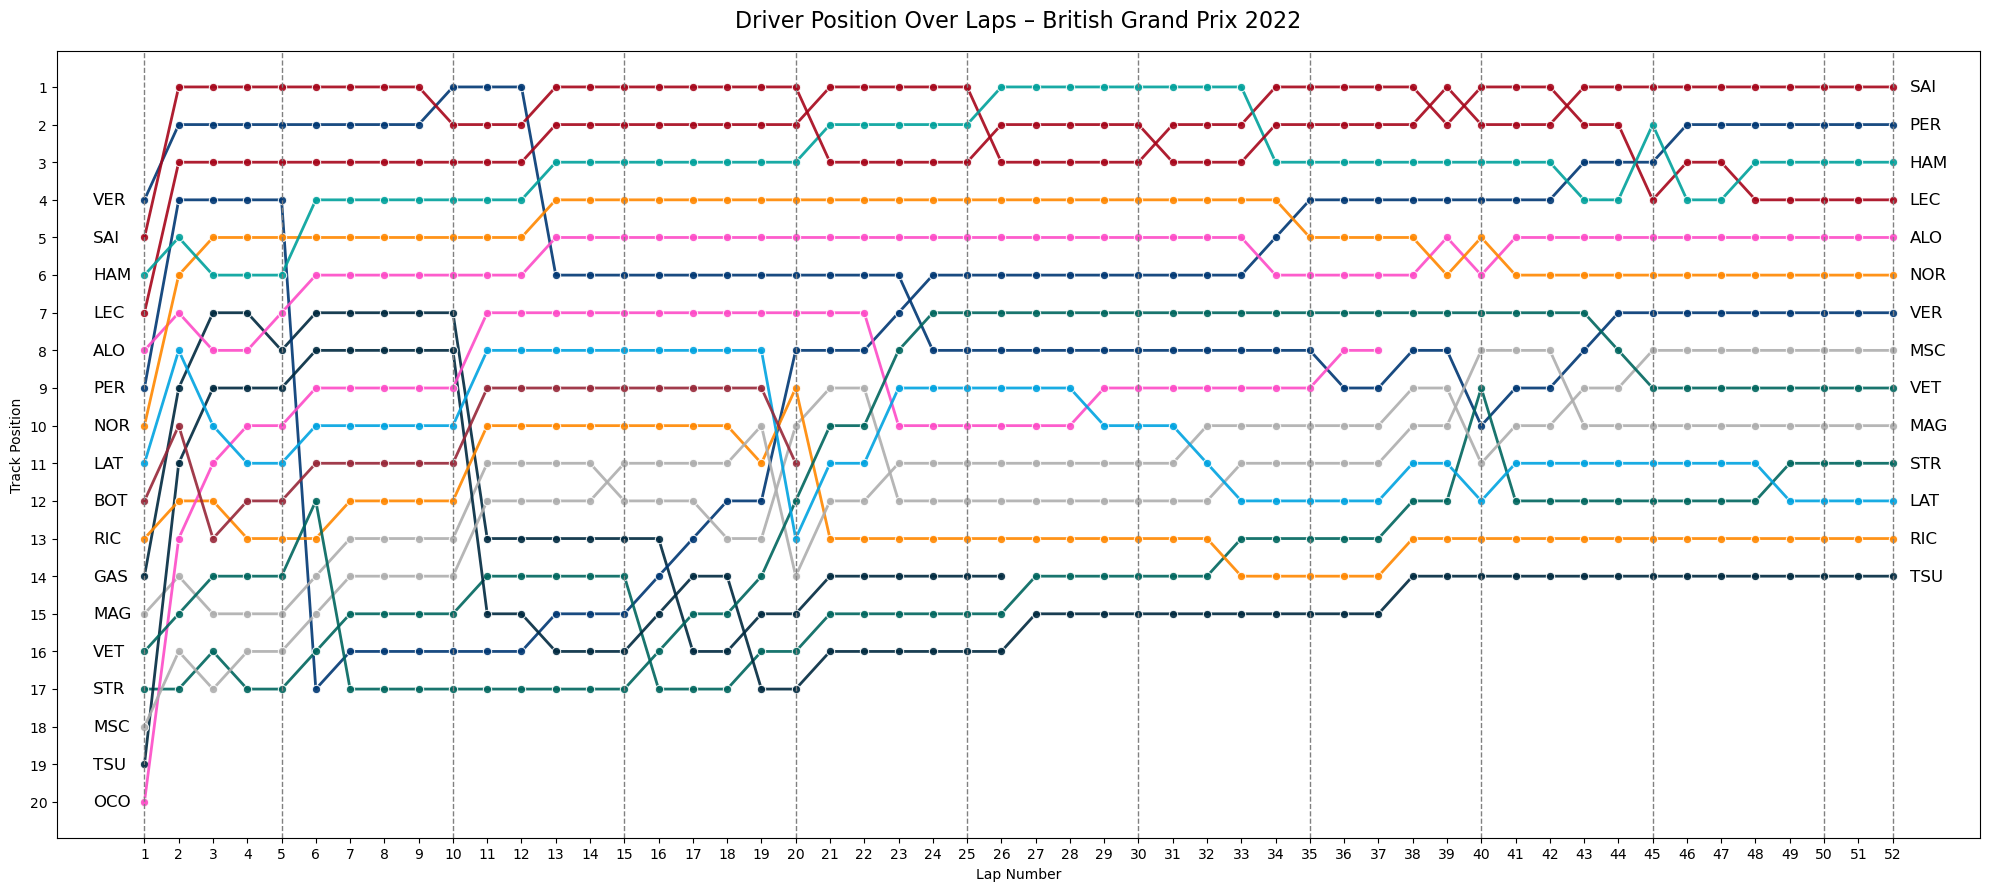

In [23]:
# Create a dictionary that maps each driver to their team color
driver_team_colors = race_df.dropna(subset=['Team']).drop_duplicates(subset=['Driver'])
driver_team_colors['Color'] = driver_team_colors['Team'].map(TEAM_COLORS)

# Create a dictionary for driver names and their corresponding team color
driver_color_map = driver_team_colors.set_index('Driver')['Color'].to_dict()

# Plot the data with team colors
plt.figure(figsize=(20, 9))

# Lineplot of Position vs LapNumber, colored by Driver's team color
sns.lineplot(
    data=race_df
    ,x='LapNumber'
    ,y='Position'
    ,hue='Driver'
    ,palette=driver_color_map  # Use the dictionary with Driver:Color mapping
    ,marker='o'
    ,linewidth=2
    ,alpha=0.9
    ,legend=False
)

# Loop over each driver for labels
for driver in race_df['Driver'].unique():
    driver_data = race_df[race_df['Driver'] == driver]

    # End of the line
    last_lap = driver_data['LapNumber'].max()
    last_pos = driver_data.loc[driver_data['LapNumber'] == last_lap, 'Position'].values[0]
    if last_lap == race_df['LapNumber'].max():
        plt.text(
            x=last_lap + 0.5
            ,y=last_pos
            ,s=driver
            ,fontsize=12
            ,va='center'
        )

    # Start of the line
    first_lap = driver_data['LapNumber'].min()
    first_pos = driver_data.loc[driver_data['LapNumber'] == first_lap, 'Position'].values[0]
    plt.text(
        x=first_lap - 1.5
        ,y=first_pos
        ,s=driver
        ,fontsize=12
        ,va='center'
    )

# Invert y-axis: Position 1 should be at the top
plt.gca().invert_yaxis()

# Set y-axis ticks to be each integer value (positions 1 to max)
plt.yticks(range(1, int(race_df['Position'].max()) + 1))

# Set x-axis to start at 1 and mark each unit
plt.xticks(range(1, int(race_df['LapNumber'].max()) + 1))

# Add vertical dashed lines every 5 units on the x-axis
for lap in range(1, int(race_df['LapNumber'].max()) + 1):
    if lap == 1 or lap % 5 == 0 or lap == int(race_df['LapNumber'].max()):
        plt.axvline(x=lap, color='gray', linestyle='--', linewidth=1)

plt.title(f'Driver Position Over Laps – {EVENT_PLT} {YEAR_PLT}', fontsize=16, y=1.02)
plt.xlabel('Lap Number')
plt.ylabel('Track Position')

plt.tight_layout()
plt.show()

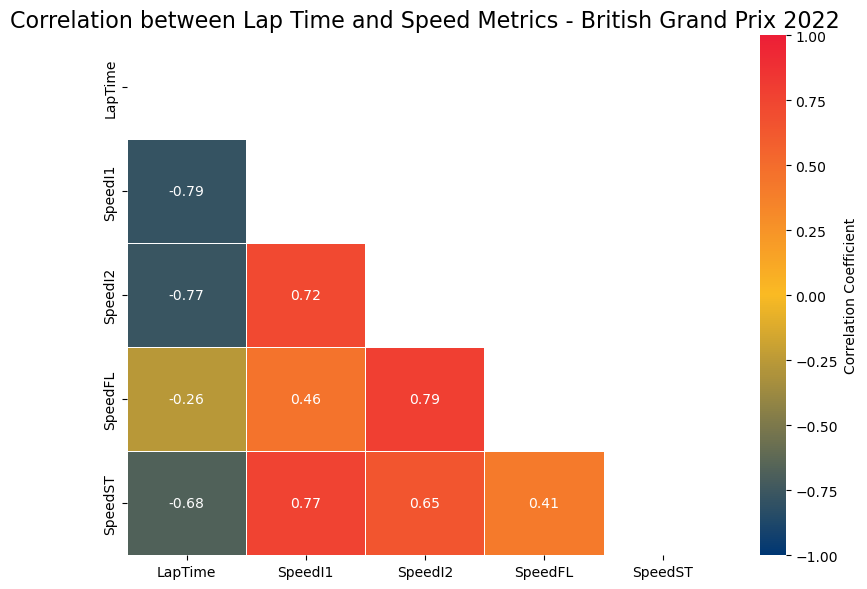

In [24]:
# Calculate correlation matrix between LapTime and speed-related features
speed_corr = race_df[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(speed_corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    speed_corr
    ,annot=True
    ,cmap=CMAP
    ,vmin=-1
    ,vmax=1
    ,fmt=".2f"
    ,linewidths=0.5
    ,cbar_kws={"label": "Correlation Coefficient"}
    ,mask=mask
)
plt.title(f"Correlation between Lap Time and Speed Metrics - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout()
plt.show()

### 2.2. Telemetry Data

In [25]:
# Filter the data, since the dataset is too large and convert to pandas for visualization purposes
telemetry_pd = (
    telemetry_data
    .filter(
        (col("EventName") == EVENT_PLT) &
        (col("Year") == YEAR_PLT)
    )
    .toPandas()
)

#### 2.2.1. Histograms

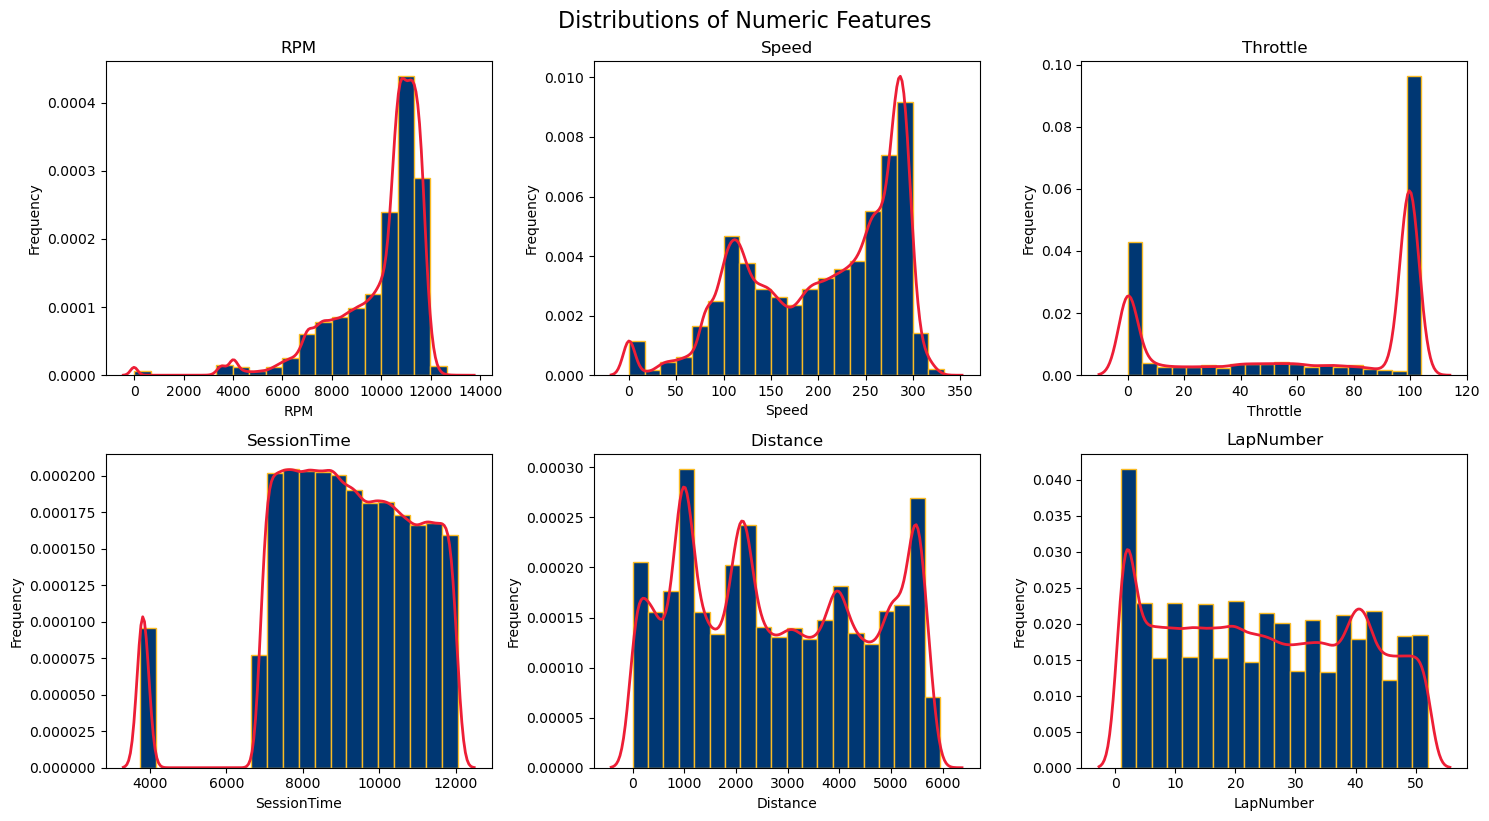

In [26]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(TELEMETRY_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot histogram and density line
for i, col_ in enumerate(TELEMETRY_METRIC):
    sns.histplot(
        data=telemetry_pd
        ,x=col_
        ,ax=axes[i]
        ,bins=sturges_bins(telemetry_pd, col_)
        ,color=BLUE
        ,edgecolor=YELLOW
        ,stat='density'
        ,alpha=1
    )

    sns.kdeplot(
        data=telemetry_pd
        ,x=col_
        ,ax=axes[i]
        ,color=RED
        ,linewidth=2
    )
    
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Numeric Features", fontsize=16, y=1.02)
plt.show()

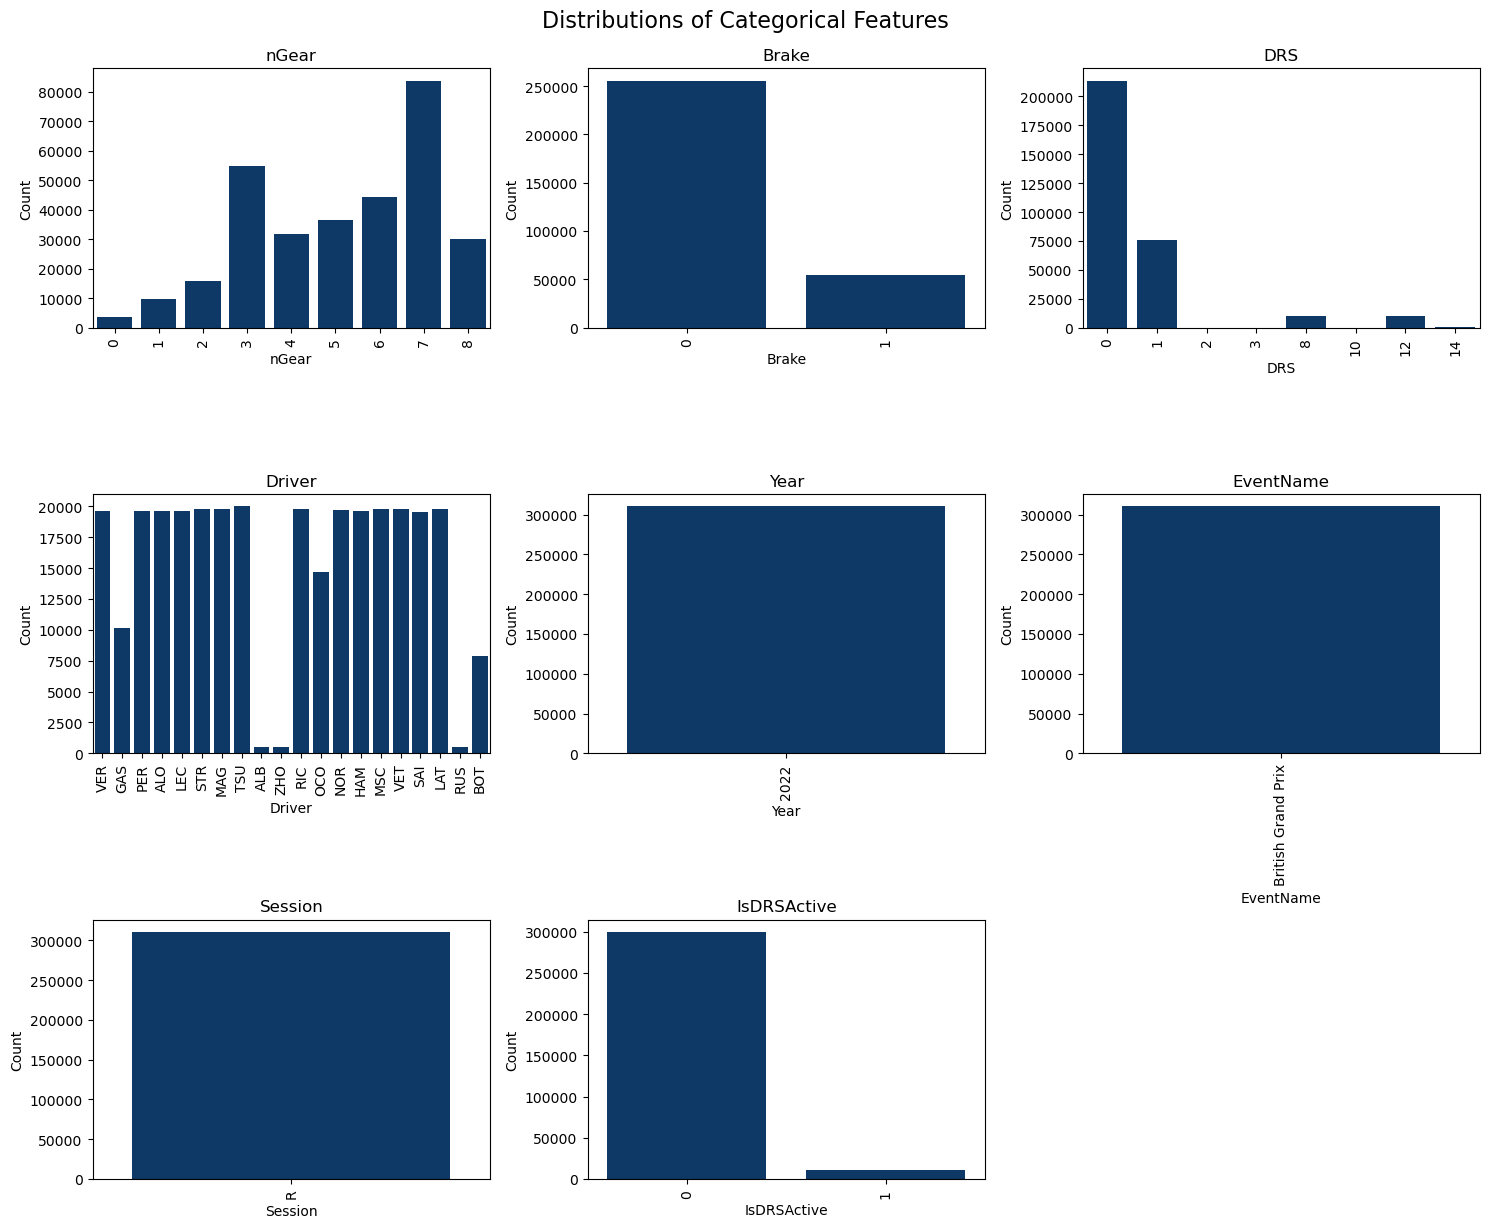

In [27]:
# Plot for categorical features
n_cols_cat = 3
n_rows_cat = int(np.ceil(len(TELEMETRY_CATEGORICAL) / n_cols_cat))
fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(15, n_rows_cat * 4))
axes_cat = axes_cat.flatten()

for i, col_ in enumerate(TELEMETRY_CATEGORICAL):
    sns.countplot(
        data=telemetry_pd[telemetry_pd[col_].notna()],
        x=col_,
        ax=axes_cat[i],
        color=BLUE
    )
    axes_cat[i].set_title(col_)
    axes_cat[i].set_xlabel(col_)
    axes_cat[i].set_ylabel("Count")
    axes_cat[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Categorical Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.2. Boxplots

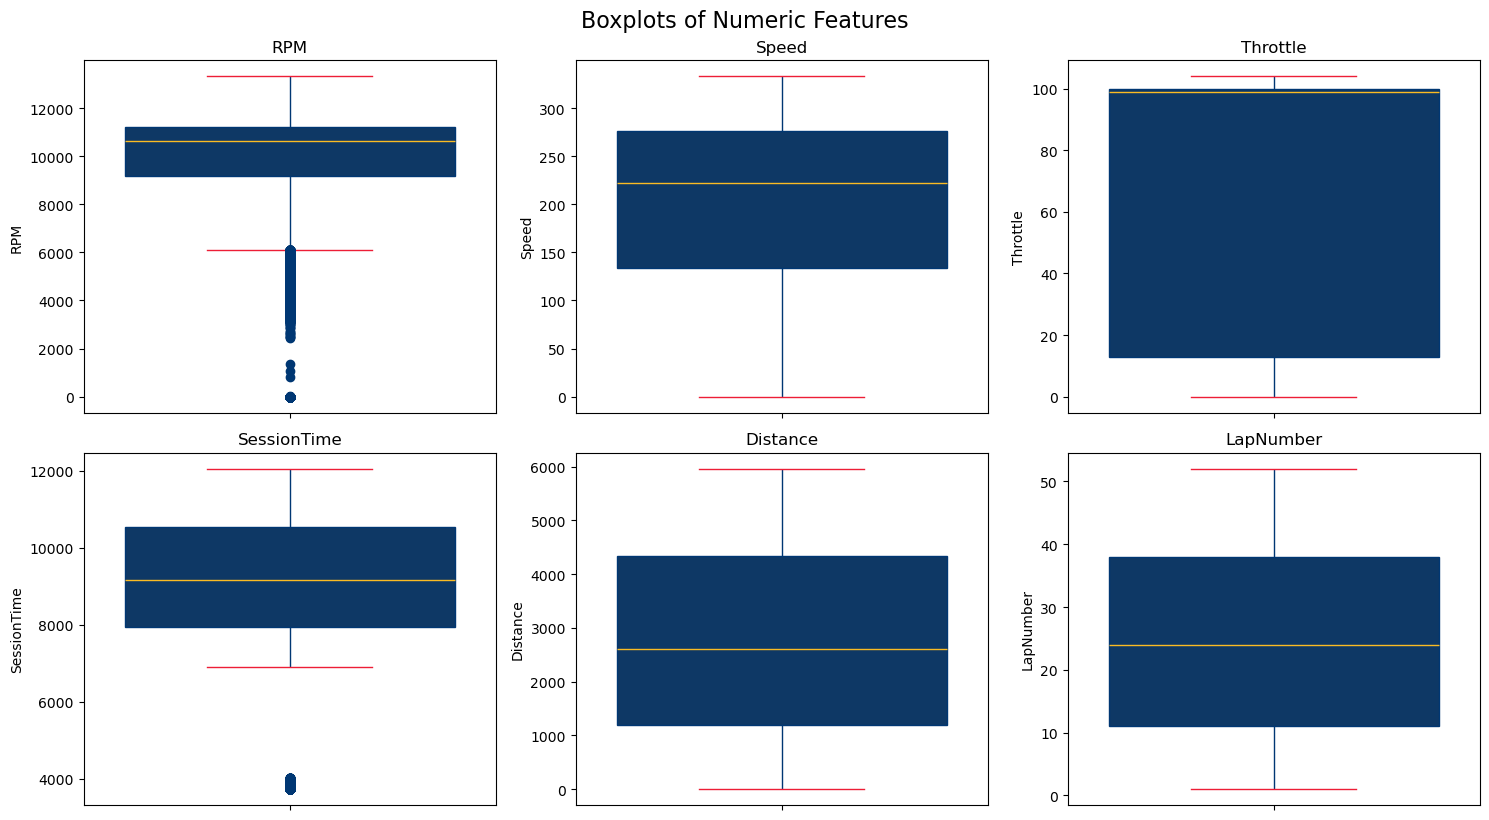

In [28]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(TELEMETRY_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col_ in enumerate(TELEMETRY_METRIC):
    sns.boxplot(y=telemetry_pd[col_], ax=axes[i], color=BLUE, boxprops=dict(edgecolor=BLUE),
        whiskerprops=dict(color=BLUE),
        capprops=dict(color=RED),
        medianprops=dict(color=YELLOW),
        flierprops=dict(markerfacecolor=BLUE, markeredgecolor=BLUE))
    axes[i].set_title(col_)
    axes[i].set_ylabel(col_)
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.3. Other Plots

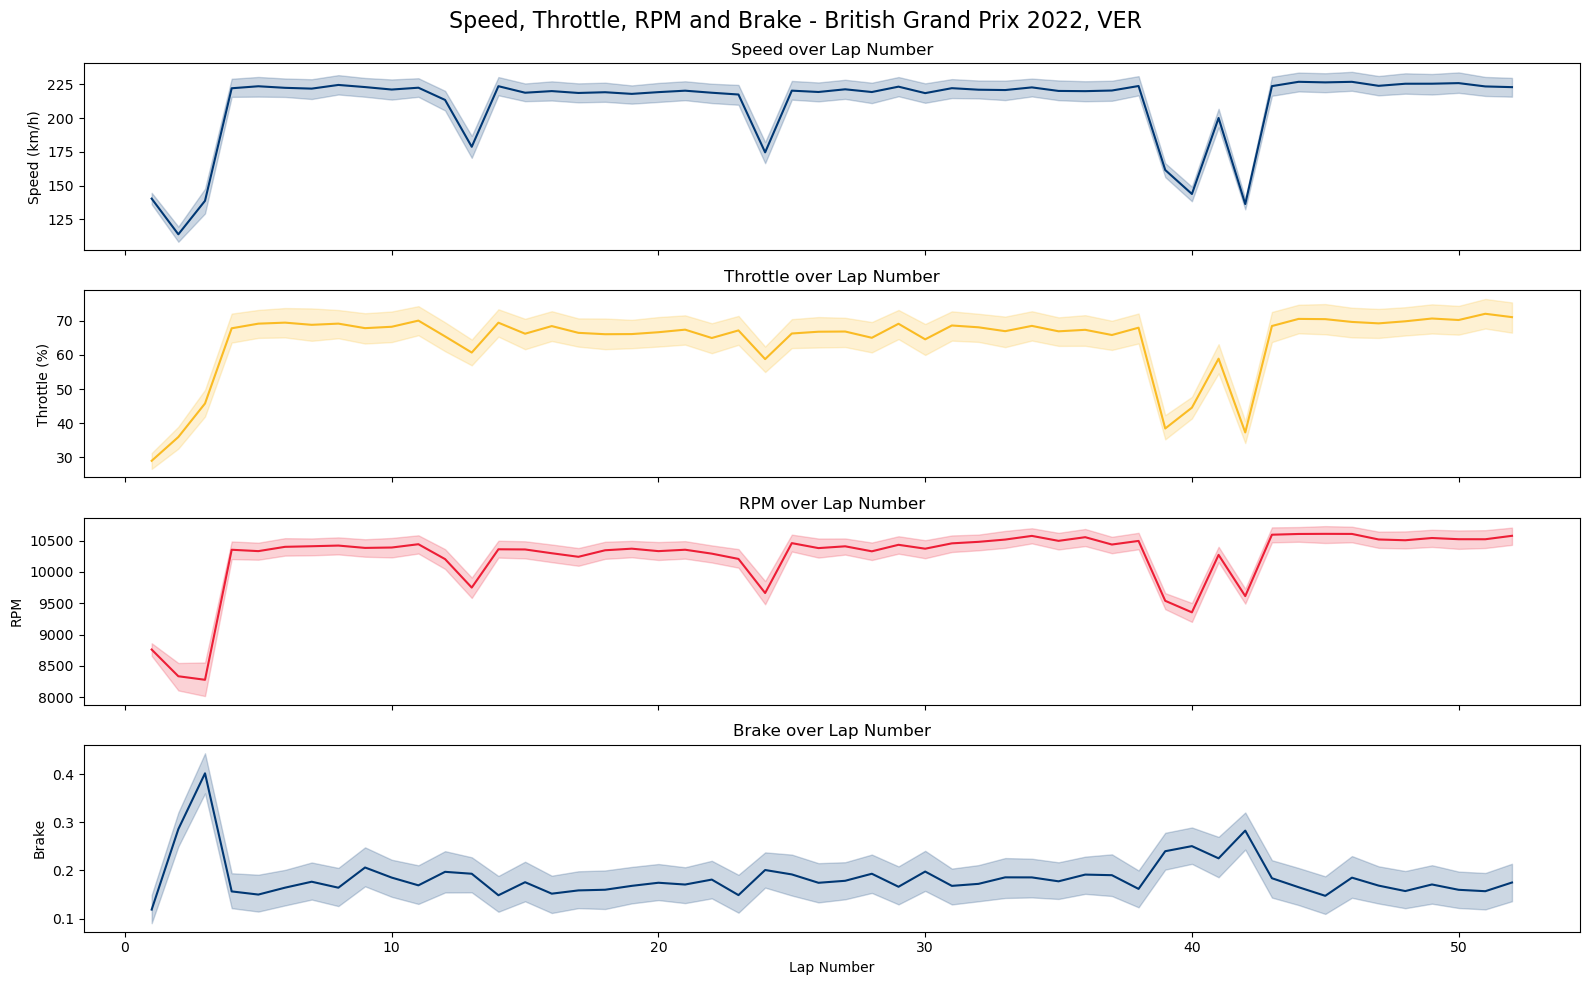

In [29]:
df_plot = telemetry_pd[(telemetry_pd['Driver'] == DRIVER_PLT)]

# Create a figure with multiple subplots
fig, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

# Plot Speed
sns.lineplot(data=df_plot, x="LapNumber", y="Speed", ax=axs[0], color=BLUE)
axs[0].set_title(f"Speed over Lap Number")
axs[0].set_ylabel("Speed (km/h)")

# Plot Throttle
sns.lineplot(data=df_plot, x="LapNumber", y="Throttle", ax=axs[1], color=YELLOW)
axs[1].set_title("Throttle over Lap Number")
axs[1].set_ylabel("Throttle (%)")

# Plot RPM
sns.lineplot(data=df_plot, x="LapNumber", y="RPM", ax=axs[2], color=RED)
axs[2].set_title("RPM over Lap Number")
axs[2].set_ylabel("RPM")
axs[2].set_xlabel("Lap Number")

# Plot Brake
sns.lineplot(data=df_plot, x="LapNumber", y="Brake", ax=axs[3], color=BLUE)
axs[3].set_title("Brake over Lap Number")
axs[3].set_ylabel("Brake")
axs[3].set_xlabel("Lap Number")

plt.suptitle(f"Speed, Throttle, RPM and Brake - {EVENT_PLT} {YEAR_PLT}, {DRIVER_PLT}", fontsize=16)

plt.tight_layout()
plt.show()

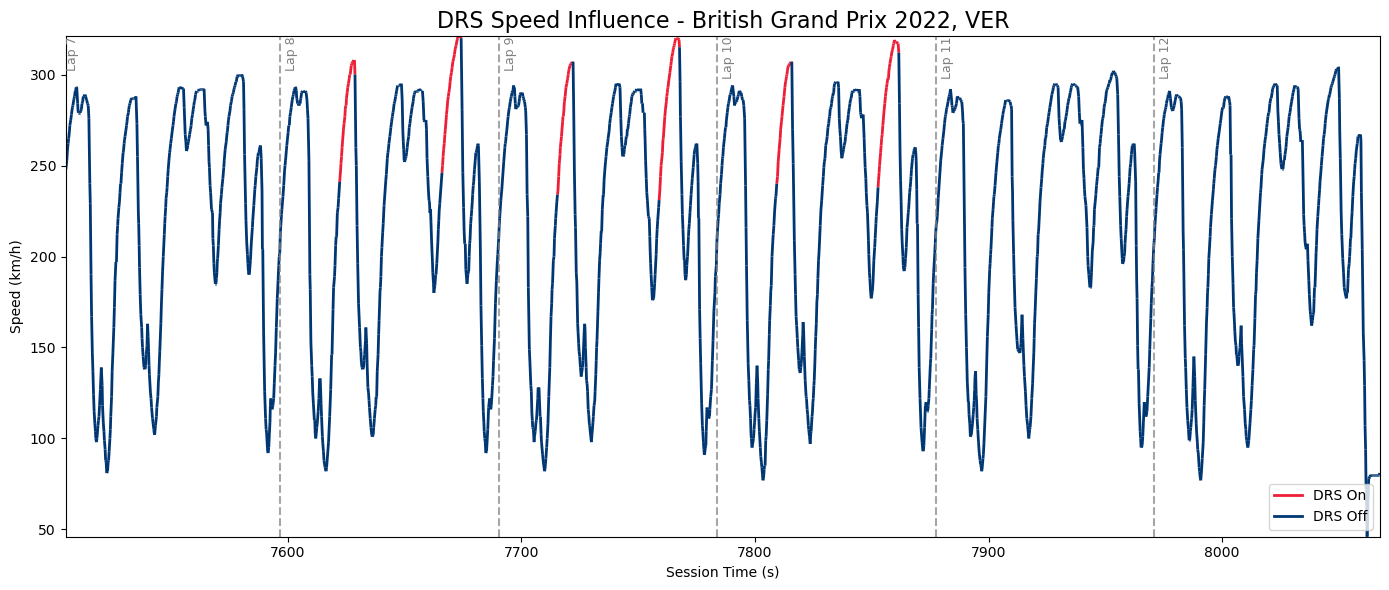

In [30]:
# Filter data
drs_plot = df_plot[(df_plot['LapNumber'] >= 7) & (df_plot['LapNumber'] <= 12)]

# First, identify where LapNumber changes (lap start points)
lap_changes = drs_plot[['SessionTime', 'LapNumber']].drop_duplicates('LapNumber')

# Prepare segments for LineCollection
x = drs_plot['SessionTime'].values
y = drs_plot['Speed'].values
c = drs_plot['IsDRSActive'].astype(int).values

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Split into DRS On and Off segments
segments_on = [seg for i, seg in enumerate(segments) if c[i] == 1]
segments_off = [seg for i, seg in enumerate(segments) if c[i] == 0]

# Create separate LineCollections
lc_on = LineCollection(segments_on, colors=RED, linewidth=2, label='DRS On')
lc_off = LineCollection(segments_off, colors=BLUE, linewidth=2, label='DRS Off')

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
ax.add_collection(lc_on)
ax.add_collection(lc_off)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(f"DRS Speed Influence - {EVENT_PLT} {YEAR_PLT}, {DRIVER_PLT}", fontsize=16)
ax.set_xlabel("Session Time (s)")
ax.set_ylabel("Speed (km/h)")

# Add vertical lines for each lap change
for _, row in lap_changes.iterrows():
    ax.axvline(x=row['SessionTime'] - 2, color='grey', linestyle='--', alpha=0.7)
    ax.text(row['SessionTime'], y.max(), f"Lap {int(row['LapNumber'])}", 
            rotation=90, verticalalignment='top', horizontalalignment='left', fontsize=9, color='grey')

# Add manual legend
legend_elements = [
    Line2D([0], [0], color=RED, lw=2, label='DRS On'),
    Line2D([0], [0], color=BLUE, lw=2, label='DRS Off')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

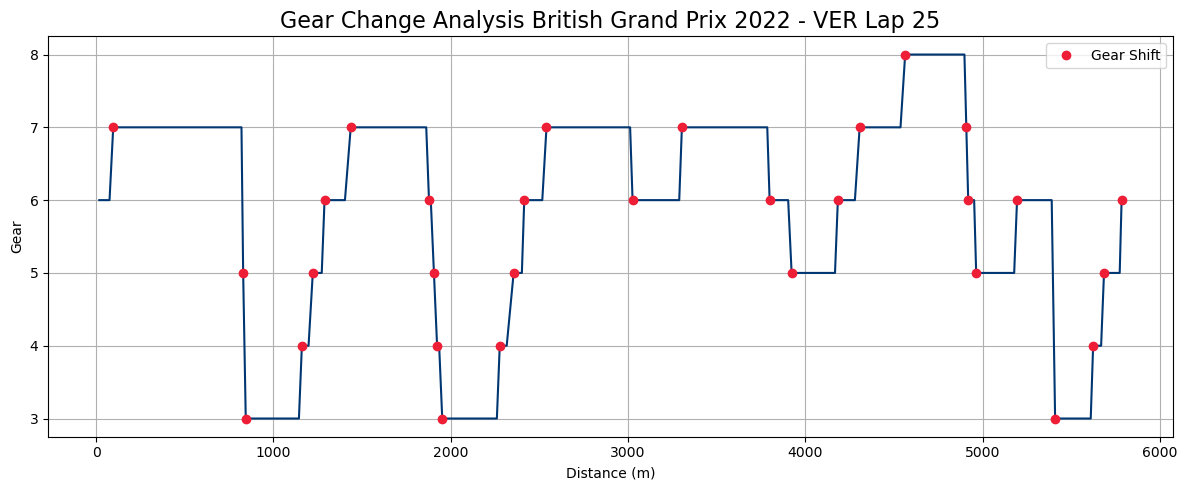

In [31]:
# Select one example lap
gear_df = df_plot[df_plot['LapNumber'] == 25].sort_values('Distance')

# Identify gear shifts
gear_diff = gear_df['nGear'].diff().fillna(0)
gear_shift_indices = gear_diff != 0

# Plotting
plt.figure(figsize=(12, 5))

# Plot the gear line
plt.plot(gear_df['Distance'], gear_df['nGear'], linestyle='-', color=BLUE)

# Overlay markers only at gear shift points
plt.plot(
    gear_df['Distance'][gear_shift_indices]
    ,gear_df['nGear'][gear_shift_indices]
    ,marker='o'
    ,linestyle='None'
    ,color=RED
    ,label='Gear Shift'
)

# Styling
plt.title(f'Gear Change Analysis {EVENT_PLT} {YEAR_PLT} - {DRIVER_PLT} Lap 25', fontsize=16)
plt.xlabel('Distance (m)')
plt.ylabel('Gear')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


## 3. Data Processing

In this section, inconsistencies and missing values are handled.

### 3.1. Inconsistencies

In [32]:
# Checking laps with no time information
lap_data.filter((
    col("Sector1Time").isNull() & 
    col("Sector2Time").isNull() & 
    col("Sector3Time").isNull()
)).show(5)

+------+------------+-------+---------+-----+----------+---------+-----------+-----------+-----------+-------+-------+-------+-------+--------------+--------+--------+---------+---------------+------------+-----------+--------+-------+---------------+----------+----+--------------------+-------+--------------+
|Driver|DriverNumber|LapTime|LapNumber|Stint|PitOutTime|PitInTime|Sector1Time|Sector2Time|Sector3Time|SpeedI1|SpeedI2|SpeedFL|SpeedST|IsPersonalBest|Compound|TyreLife|FreshTyre|           Team|LapStartTime|TrackStatus|Position|Deleted|FastF1Generated|IsAccurate|Year|           EventName|Session|LapSessionTime|
+------+------------+-------+---------+-----+----------+---------+-----------+-----------+-----------+-------+-------+-------+-------+--------------+--------+--------+---------+---------------+------------+-----------+--------+-------+---------------+----------+----+--------------------+-------+--------------+
|   GAS|          10|   NULL|       45|    3|      NULL|     NUL

In [33]:
# Flagging drivers who DNF on the following lap
window_spec = Window.partitionBy("Year", "EventName", "Session", "Driver").orderBy("LapNumber")

lap_data = lap_data.withColumn(
    'DNF',
    when(
        lag(
            when(
                (col("Sector1Time").isNull() & 
                 col("Sector2Time").isNull() & 
                 col("Sector3Time").isNull()),
                1
            ).otherwise(0),
            -1
        ).over(window_spec) == 1,
        1
    ).otherwise(0)
)

In [34]:
# Removing them rows
lap_data = (
    lap_data
    .filter(~(
        col("Sector1Time").isNull() & 
        col("Sector2Time").isNull() & 
        col("Sector3Time").isNull()
    ))
)

### 3.2. Missing Values

#### 3.2.1. Lap Data

In [35]:
# Compute null counts
null_counts = lap_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in lap_data.columns])

# Convert to a Row to filter in Python
null_counts_dict = null_counts.first().asDict()

# Filter and print only columns with nulls
for col_name, count in null_counts_dict.items():
    if count > 0:
        print(f"{col_name}: {count}")

LapTime: 878
PitOutTime: 46152
PitInTime: 46132
Sector1Time: 954
Sector2Time: 2
Sector3Time: 91
SpeedI1: 7109
SpeedI2: 1
SpeedFL: 1780
SpeedST: 3843


**Lap Time**

In [36]:
# Check missing values
lap_data.filter(col("LapTime").isNull()).count()

878

In [37]:
# Fix missing values - compute by subtracting the time at the end and at the start of the lap
lap_data = lap_data.withColumn("LapTime", col("LapSessionTime") - col("LapStartTime"))

In [38]:
# Recheck
lap_data.filter(col("LapTime").isNull()).count()

0

**PitOutTime**, **PitInTime** - Does not make sense to fill in these missing values; these features will be used for feature engineering.

**Sector1Time**, **Sector2Time**, **Sector3Time** - These features will be used for feature engineering, no need to fill them.

**SpeedI1**, **SpeedI2**, **SpeedFL**, **SpeedST**

In [39]:
# Check missing values
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

11587

In [40]:
# Fill missing values - speed rolling average
driver_lap_window = (
    Window
    .partitionBy("Year", "EventName", "Session", "Driver")
    .orderBy("LapNumber")
    .rowsBetween(Window.unboundedPreceding, -1)
)

# List of columns to process
speed_cols = ["SpeedI1", "SpeedI2", "SpeedFL", "SpeedST"]

# Fill missing values
for col_name in speed_cols:
    cumulative_avg = avg(col(col_name)).over(driver_lap_window)
    lap_data = (
        lap_data
        .withColumn(
            col_name,
            when(col(col_name).isNull(), cumulative_avg).otherwise(col(col_name))
        )
    )

In [41]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

100

In [42]:
# Fill missing values - teammate's speed in same lap

# Self-join on teammate info
teammate_join = lap_data.alias("self").join(
    lap_data.alias("tm"),
    on=[
        col("self.Year") == col("tm.Year"),
        col("self.EventName") == col("tm.EventName"),
        col("self.Session") == col("tm.Session"),
        col("self.Team") == col("tm.Team"),
        col("self.LapNumber") == col("tm.LapNumber"),
        col("self.Driver") != col("tm.Driver")
    ],
    how="left"
)

# Replace missing values from teammate values
updated_cols = [
    coalesce(col(f"self.{col_name}"), col(f"tm.{col_name}")).alias(col_name)
    if col_name in speed_cols else col(f"self.{col_name}")
    for col_name in lap_data.columns
]

lap_data = teammate_join.select(*updated_cols)

In [43]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

58

In [44]:
# Fill missing values - finish line speed with longest straight speed
lap_data = (
    lap_data
    .withColumn(
        "SpeedFL",
        when(col("SpeedFL").isNull(), col("SpeedST")).otherwise(col("SpeedFL"))
    )
)

In [45]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

0

#### 3.2.2. Telemetry Data

In [66]:
# Compute null counts
null_counts = telemetry_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in telemetry_data.columns])

# Convert to a Row to filter in Python
null_counts_dict = null_counts.first().asDict()

# Filter and print only columns with nulls
for col_name, count in null_counts_dict.items():
    if count > 0:
        print(f"{col_name}: {count}")

DriverNumber: 89
LapTime: 89
Stint: 89
SpeedI1: 89
SpeedI2: 89
SpeedFL: 89
SpeedST: 89
IsPersonalBest: 89
Compound: 89
TyreLife: 89
FreshTyre: 89
Team: 89
LapStartTime: 89
TrackStatus: 89
Position: 89
Deleted: 89
FastF1Generated: 89
IsAccurate: 89
LapSessionTime: 89
DNF: 89
rolling_avg_laptime: 89
pit_in_lap: 89
pit_exit_lap: 89
last_pit_lap: 89
laps_since_last_pit: 89
prev_compound: 89
pit_stop_duration: 89
max_pit_stop_duration: 89
start_position: 89
position_change_since_race_start: 89
fastest_sector: 89


No missing values :)

## 4. Data Engineering

### 4.1. Lap Data

In [47]:
# Define windows
start_position_window = Window.partitionBy("Year", "EventName", "Session", "Driver")
lap_order_window = start_position_window.orderBy("LapNumber")

In [48]:
# Creating new features
lap_data = (
    lap_data
    .withColumn("rolling_avg_laptime", avg("LapTime").over(lap_order_window.rowsBetween(Window.unboundedPreceding, 0)))
    .withColumn("pit_in_lap", when(col("PitInTime").isNotNull(), 1).otherwise(0))
    .withColumn("pit_exit_lap", when(col("PitOutTime").isNotNull(), 1).otherwise(0))
    .withColumn(
        "last_pit_lap",
        coalesce(
            max("pit_exit_lap").over(lap_order_window.rowsBetween(Window.unboundedPreceding, 0)),
            lit(0)
        )
    )
    .withColumn("laps_since_last_pit", col("LapNumber") - col("last_pit_lap"))
    .withColumn(
        "prev_compound", 
        when(
            col("LapNumber") == 1, col("Compound")
        ).otherwise(
            lag("Compound").over(lap_order_window)
        )
    )
    .withColumn(
        "pit_stop_duration",
        when(
            (col("PitOutTime").isNull()) | ((col("PitOutTime").isNotNull()) & (col("LapNumber") == 1)),
            lit(0)
        ).otherwise(
            col("PitOutTime") - lag("PitInTime").over(lap_order_window)
        )
    )
    .withColumn("max_pit_stop_duration", max("pit_stop_duration").over(lap_order_window))
    .withColumn("start_position", first(when(col("LapNumber") == 1, col("Position")), ignorenulls=True).over(start_position_window))
    .withColumn("position_change_since_race_start", col("start_position") - col("Position"))
    .withColumn(
        "fastest_sector", when(
            (col("Sector1Time") <= col("Sector2Time")) & (col("Sector1Time") <= col("Sector3Time")), 1
        ).when(
            (col("Sector2Time") <= col("Sector1Time")) & (col("Sector2Time") <= col("Sector3Time")), 2
        ).otherwise(3)
    )
)

In [49]:
lap_data = lap_data.drop(
    "Sector1Time", "Sector2Time", "Sector3Time", "PitOutTime"
)

In [50]:
lap_data.show(1)

+------+------------+-----------------+---------+-----+---------+-------+-------+-------+-------+--------------+--------+--------+---------+------+------------+-----------+--------+-------+---------------+----------+----+--------------------+-------+--------------+---+-------------------+----------+------------+------------+-------------------+-------------+-----------------+---------------------+--------------+--------------------------------+--------------+
|Driver|DriverNumber|          LapTime|LapNumber|Stint|PitInTime|SpeedI1|SpeedI2|SpeedFL|SpeedST|IsPersonalBest|Compound|TyreLife|FreshTyre|  Team|LapStartTime|TrackStatus|Position|Deleted|FastF1Generated|IsAccurate|Year|           EventName|Session|LapSessionTime|DNF|rolling_avg_laptime|pit_in_lap|pit_exit_lap|last_pit_lap|laps_since_last_pit|prev_compound|pit_stop_duration|max_pit_stop_duration|start_position|position_change_since_race_start|fastest_sector|
+------+------------+-----------------+---------+-----+---------+-------

### 4.2. Telemetry Data

In [51]:
# Define window
window_spec = Window.partitionBy("Year", "EventName", "Driver", "LapNumber").orderBy("SessionTime")
last_50_window = window_spec.rowsBetween(-49, 0)

In [52]:
# Compute per-lap aggregates
telemetry_data = (
    telemetry_data
    .withColumn("avg_speed_last_lap", avg("Speed").over(window_spec))
    .withColumn("max_speed_last_lap", max("Speed").over(window_spec))
    .withColumn("avg_throttle_last_lap", avg("Throttle").over(window_spec))
    .withColumn("avg_brake_last_lap", avg("Brake").over(window_spec))
    .withColumn("avg_rpm", avg("RPM").over(window_spec))
    .withColumn("gear_change", when(col("nGear") != lag("nGear").over(window_spec), 1).otherwise(0))
    .withColumn("gear_change_count", sum("gear_change").over(window_spec))
    .withColumn(
        "DRS_activation_count",
        sum(
            when(
                (~lag("DRS").over(window_spec).isin(10, 12, 14)) & (col("DRS").isin(10, 12, 14)),
                1
            ).otherwise(0)
        ).over(window_spec.rowsBetween(Window.unboundedPreceding, 0))
    )
    .withColumn("rolling_throttle_mean", avg("Throttle").over(last_50_window))
    .withColumn("rolling_brake_intensity", avg("Brake").over(last_50_window))
    .withColumn("rolling_gear_change", when(col("nGear") != lag("nGear").over(window_spec), 1).otherwise(0))
    .withColumn("rolling_gear_change_rate", avg("rolling_gear_change").over(last_50_window))
    .withColumn("rolling_speed_mean", avg("Speed").over(last_50_window))
)

In [53]:
# Final sector features (define final 5% of distance per lap)
max_distance = telemetry_data.groupBy("Year", "EventName", "Driver", "LapNumber").agg(max("Distance").alias("max_dist"))
telemetry_data = telemetry_data.join(max_distance, on=["Year", "EventName", "Driver", "LapNumber"])
telemetry_data = telemetry_data.withColumn("in_final_sector", col("Distance") >= col("max_dist") * 0.95)

# Define new window
final_sector_window = Window.partitionBy("Year", "EventName", "Driver", "LapNumber").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

telemetry_data = (
    telemetry_data
    .withColumn("final_sector_avg_speed", avg(when(col("in_final_sector"), col("Speed"))).over(final_sector_window))
    .withColumn("final_sector_throttle", avg(when(col("in_final_sector"), col("Throttle"))).over(final_sector_window))
    .withColumn("final_sector_brake", avg(when(col("in_final_sector"), col("Brake"))).over(final_sector_window))
)

In [54]:
# telemetry_data.show(1)

In [55]:
# Select final per-lap features
lap_feature_cols = [
    "EventName", "Driver", "LapNumber", "Year", "Session",
    "avg_speed_last_lap", "max_speed_last_lap",
    "avg_throttle_last_lap", "avg_brake_last_lap",
    "gear_change_count", "avg_rpm", "DRS_activation_count",
    "rolling_throttle_mean", "rolling_brake_intensity",
    "rolling_gear_change_rate", "rolling_speed_mean",
    "final_sector_avg_speed", "final_sector_throttle", 
    "final_sector_brake"
]

# For all columns, take the FIRST value per (Driver, LapNumber)
# Because window functions already populated each row with the same value within each lap
aggregated_laps = (
    telemetry_data
    .select(*lap_feature_cols)
    .groupBy("Year", "EventName", "Session", "Driver", "LapNumber")
    .agg(*[
        first(col_name).alias(col_name) 
        if col_name != "DRS_activation_count" 
        else last(col_name).alias(col_name) 
        for col_name in lap_feature_cols 
        if col_name not in ("Year", "EventName", "Session", "Driver", "LapNumber")
    ])
)

In [56]:
# aggregated_laps.show(5)

### Joining the Data

In [90]:
# Join lap_data and telemetry_data
data = (
    lap_data
    .alias('lap')
    .join(
        aggregated_laps.alias('telemetry')
        ,on=["Year", "EventName", "Session", "Driver", "LapNumber"]
        ,how="inner"
    )
)

In [91]:
# Create target variable
data = (
    data
    .withColumn(
        "WillPitNextLap", when(
            lead("PitInTime", 1).over(Window.partitionBy("Year", "EventName", "Session", "Driver").orderBy("LapNumber")).isNotNull(), 1
        )
    .otherwise(0)
    )
)

data = data.drop("PitInTime")

In [92]:
# data.show(1)

In [93]:
# data.printSchema()

## Data Modelling

In [94]:
# Convert categorical features to numerical values
indexers = [
    StringIndexer(inputCol="Team", outputCol="TeamIndex"),
    StringIndexer(inputCol="Compound", outputCol="CompoundIndex"),
    StringIndexer(inputCol="Driver", outputCol="DriverIndex"),
    StringIndexer(inputCol="EventName", outputCol="EventNameIndex")
]

In [95]:
# Assemble all features into a single vector column for the model
feature_columns = [
    # Telemetry / strategy features
    'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre', 'TrackStatus',
    'Position', 'rolling_avg_laptime', 'laps_since_last_pit',
    'pit_stop_duration', 'max_pit_stop_duration',
    'position_change_since_race_start',
    'avg_speed_last_lap', 'avg_throttle_last_lap', 'avg_brake_last_lap',
    'avg_rpm', 'gear_change_count',
    'rolling_throttle_mean', 'rolling_brake_intensity',
    'rolling_gear_change_rate', 'rolling_speed_mean',
    'final_sector_avg_speed', 'final_sector_throttle', 'final_sector_brake',

    # Categorical features (indexed)
    'TeamIndex', 'CompoundIndex', 'DriverIndex', 'EventNameIndex'
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [96]:
# Train test split
train_data = data.filter(~((col("EventName") == "Abu Dhabi Grand Prix") & (col("Year") == 2023)))
test_data = data.filter((col("EventName") == "Abu Dhabi Grand Prix") & (col("Year") == 2023))

In [97]:
# Build the model
classifier = RandomForestClassifier(labelCol="WillPitNextLap", featuresCol="features")

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, classifier])

In [98]:
# Train the model
model = pipeline.fit(train_data)

In [99]:
# Make predictions on the test set
predictions = model.transform(test_data)

In [100]:
predictions.select("features", "WillPitNextLap", "prediction").show()

+--------------------+--------------+----------+
|            features|WillPitNextLap|prediction|
+--------------------+--------------+----------+
|[2023.0,1.0,1.0,2...|             0|       0.0|
|[2023.0,2.0,1.0,3...|             0|       0.0|
|[2023.0,3.0,1.0,4...|             0|       0.0|
|[2023.0,4.0,1.0,5...|             0|       0.0|
|[2023.0,5.0,1.0,6...|             0|       0.0|
|[2023.0,6.0,1.0,7...|             0|       0.0|
|[2023.0,7.0,1.0,8...|             0|       0.0|
|[2023.0,8.0,1.0,9...|             0|       0.0|
|[2023.0,9.0,1.0,1...|             0|       0.0|
|[2023.0,10.0,1.0,...|             0|       0.0|
|[2023.0,11.0,1.0,...|             0|       0.0|
|[2023.0,12.0,1.0,...|             0|       0.0|
|[2023.0,13.0,1.0,...|             0|       0.0|
|[2023.0,14.0,1.0,...|             0|       0.0|
|[2023.0,15.0,1.0,...|             1|       0.0|
|[2023.0,16.0,1.0,...|             0|       0.0|
|[2023.0,17.0,2.0,...|             0|       0.0|
|[2023.0,18.0,2.0,..

TODO: better showing of predictions - bellow is some GPT code that could be implemented

from pyspark.ml.functions import vector_to_array

# Convert 'features' column to an array of values
predictions_with_array = predictions.withColumn("features_array", vector_to_array("features"))

# Replace these names with your original input column names and their order in the assembler
original_feature_names = ["SpeedFL", "SpeedI1", "SpeedI2", "SpeedST"]

# Add each feature back as its own column
for i, name in enumerate(original_feature_names):
    predictions_with_array = predictions_with_array.withColumn(name, predictions_with_array["features_array"][i])

predictions_with_array.select(*original_feature_names, "WillPitNextLap", "prediction").show()


In [101]:
# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="WillPitNextLap", metricName="areaUnderPR")

In [102]:
# Evaluate and print the areaUnderPR score
aupr = evaluator.evaluate(predictions)
print(f"areaUnderPR: {aupr}")

areaUnderPR: 0.11884859828088591
